/users/koketso/.venv/deepclustering3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-08-14 20:16:55.650559: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755195416.254086 3058405 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755195416.382909 3058405 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-14 20:16:57.438066: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-



Failed to import TF-Keras. Please note that TF-Keras is not installed by default when you install TensorFlow Probability. This is so that JAX-only users do not have to install TensorFlow or TF-Keras. To use TensorFlow Probability with TensorFlow, please install the tf-keras or tf-keras-nightly package.
This can be be done through installing the tensorflow-probability[tf] extra.


Train Accuracy: 10.53%
Test Accuracy: 10.49%
Variance to keep :  0.12398823703451858  number of components :  3
11.080113702061862
13.14793477631498
-0.6349332332611084
-0.6316711902618408
-0.6326723098754883
-0.6341750621795654
-0.6327474117279053
Chi-Square score:  1
Repley's K:  (0.28570270614970367, 0.005212916187849785)
Epoch [2/100], Loss: 4.9625
Train Accuracy: 66.94%
Test Accuracy: 67.28%
Variance to keep :  0.5539862076435502  number of components :  3
[30.173871180706243, 3.738133341550897]


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1920x1440 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

<Figure size 1920x1440 with 0 Axes>

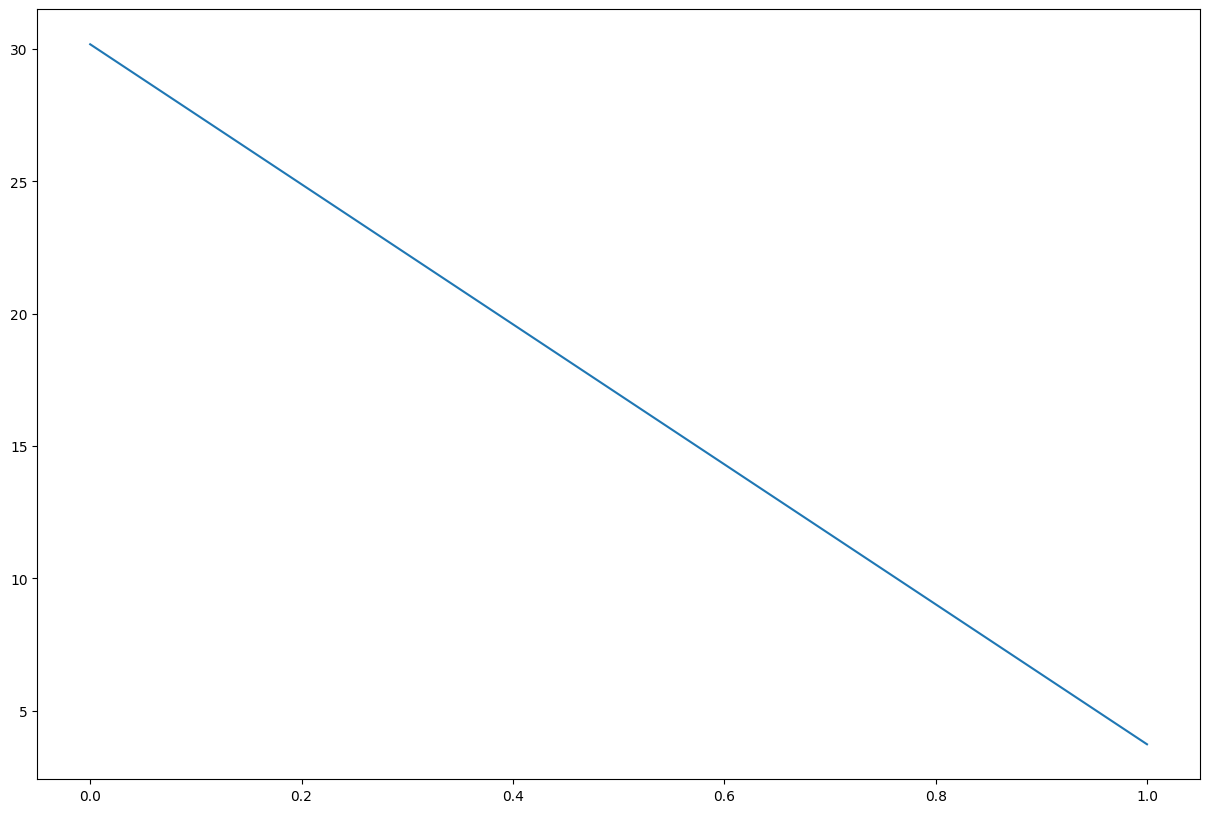

10.518298862975001
11.498997671628223
-0.4513373374938965
-0.4448084831237793
-0.44473862648010254
-0.4519157409667969
-0.4436488151550293
Chi-Square score:  1
Repley's K:  (131.42426971521184, 5.321314003049426)


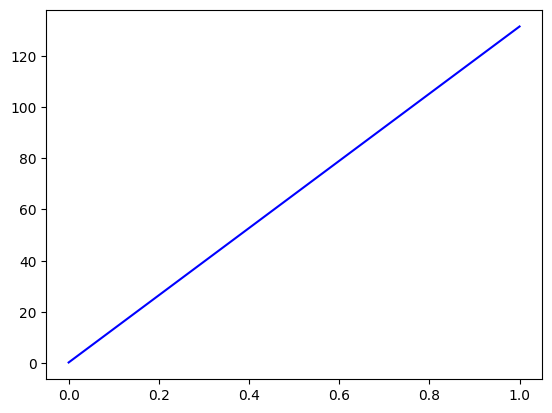

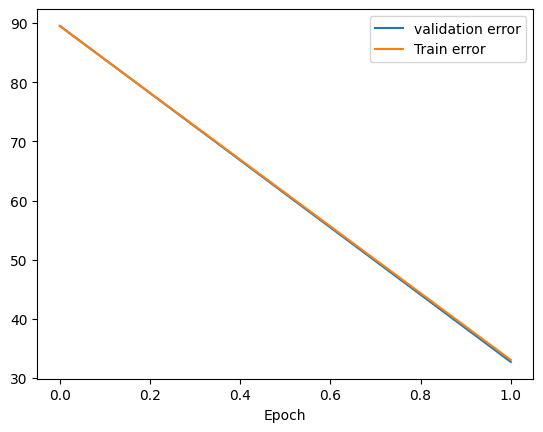

Epoch [3/100], Loss: 3.7272
Train Accuracy: 74.27%
Test Accuracy: 73.56%
Variance to keep :  0.5063735028877883  number of components :  3
[30.173871180706243, 3.738133341550897, 4.169588514691454]


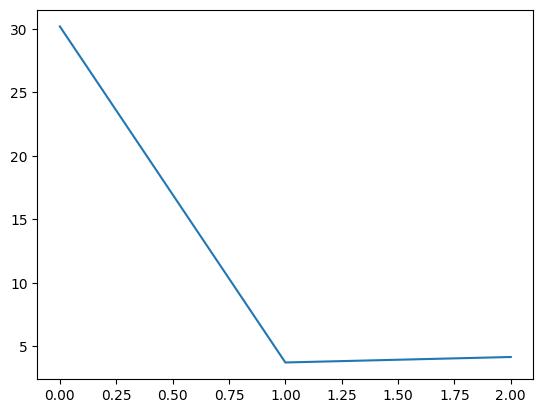

11.548471058811026
12.59364238094976
-0.38992810249328613
-0.40015387535095215
-0.3996584415435791
-0.3958394527435303
-0.4000823497772217
Chi-Square score:  1
Repley's K:  (499.281340413122, 10.731236951301966)


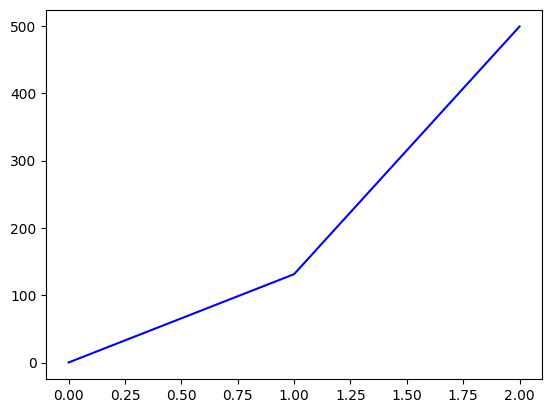

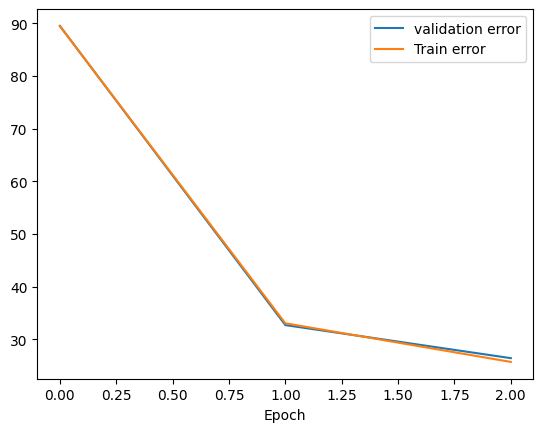

Epoch [4/100], Loss: 3.4129
Train Accuracy: 73.22%
Test Accuracy: 72.73%
Variance to keep :  0.46987917066058926  number of components :  3
[30.173871180706243, 3.738133341550897, 4.169588514691454, 2.2940561276712494]


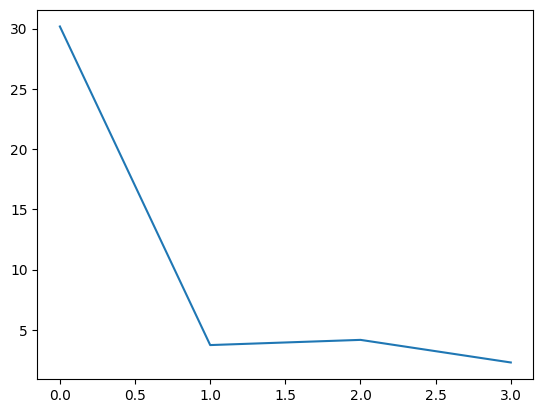

10.350415410522924
11.258099243869164
-0.42199110984802246
-0.4181661605834961
-0.41796135902404785
-0.4171328544616699
-0.41751742362976074
Chi-Square score:  1
Repley's K:  (719.4816598405266, 31.204317147144273)


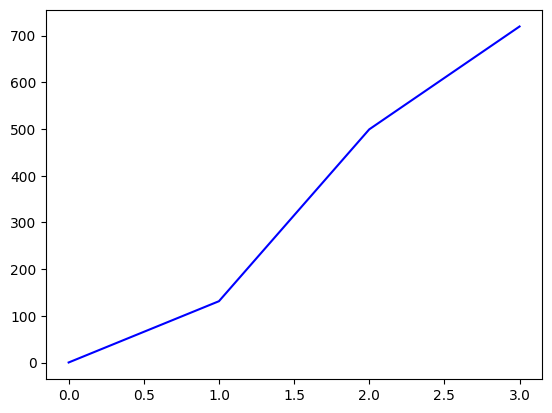

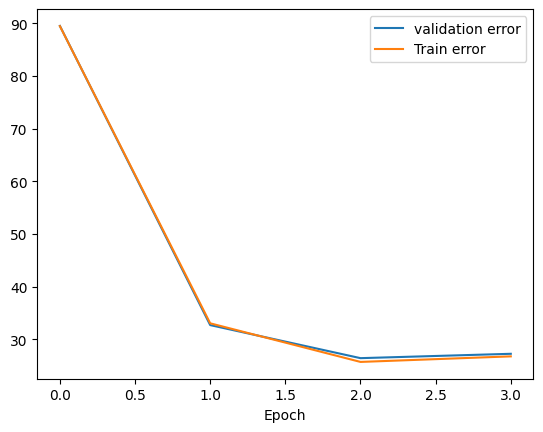

Epoch [5/100], Loss: 3.2069
Train Accuracy: 80.09%
Test Accuracy: 79.76%
Variance to keep :  0.4717741981818956  number of components :  3
[30.173871180706243, 3.738133341550897, 4.169588514691454, 2.2940561276712494, 2.126468509374429]


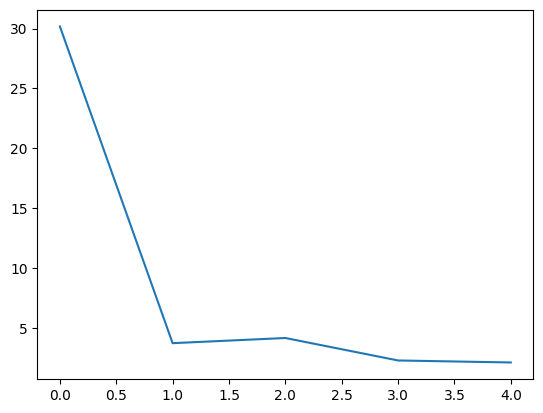

12.979281862350227
14.520006486167615
-0.3536999225616455
-0.35520005226135254
-0.35560083389282227
-0.34800219535827637
-0.35707640647888184
Chi-Square score:  1
Repley's K:  (561.8464231374978, 12.491523773070828)


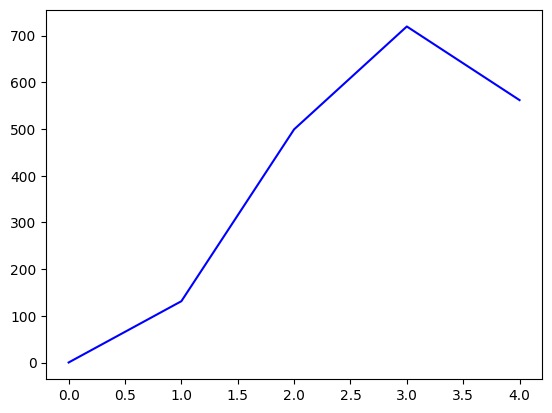

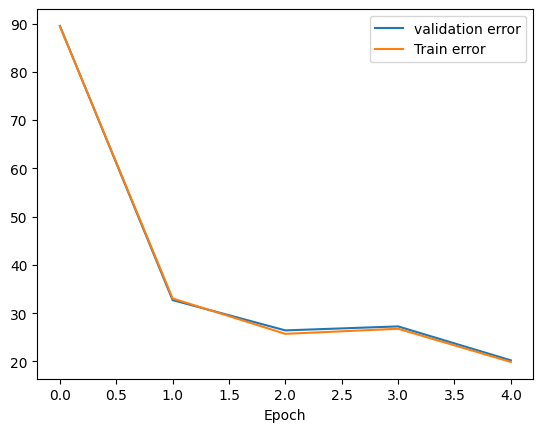

Epoch [6/100], Loss: 3.0273
Train Accuracy: 79.48%
Test Accuracy: 78.61%
Variance to keep :  0.4577312458568291  number of components :  3
[30.173871180706243, 3.738133341550897, 4.169588514691454, 2.2940561276712494, 2.126468509374429, 2.97799409739451]


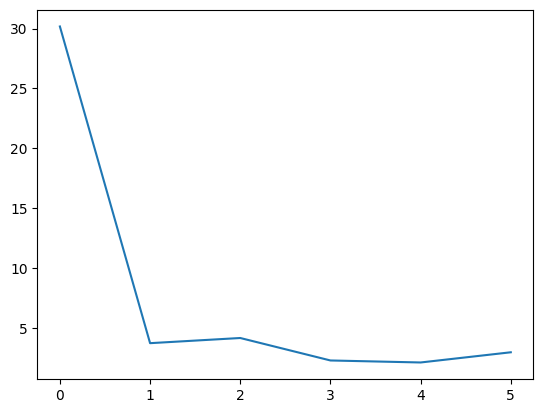

11.843090947253664
12.940220100549576
-0.4044156074523926
-0.40056586265563965
-0.39902806282043457
-0.3974771499633789
-0.403867244720459
Chi-Square score:  1
Repley's K:  (770.5671629956877, 31.799378142188743)


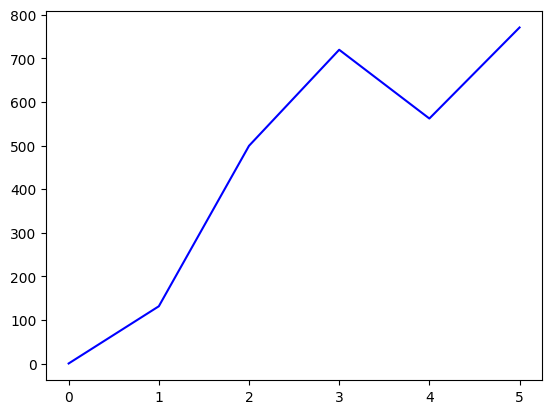

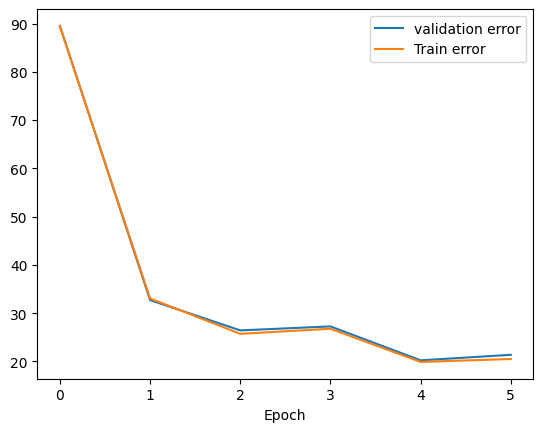

Epoch [7/100], Loss: 2.8474
Train Accuracy: 80.48%
Test Accuracy: 79.48%
Variance to keep :  0.480193499849694  number of components :  3
[30.173871180706243, 3.738133341550897, 4.169588514691454, 2.2940561276712494, 2.126468509374429, 2.97799409739451, 5.222482064279941]


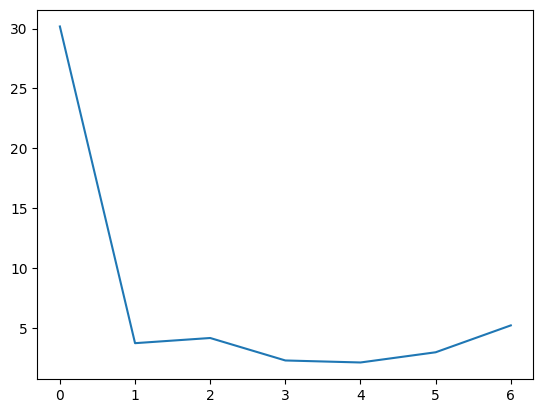

13.287244678871023
13.859364087636363
-0.4055187702178955
-0.4008362293243408
-0.4005007743835449
-0.3970348834991455
-0.39783239364624023
Chi-Square score:  1
Repley's K:  (476.44240411414984, 17.31558775699679)


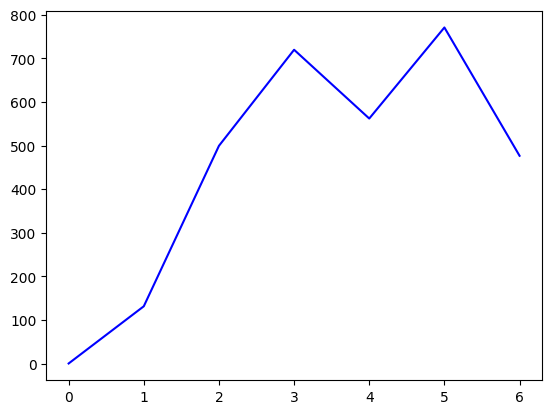

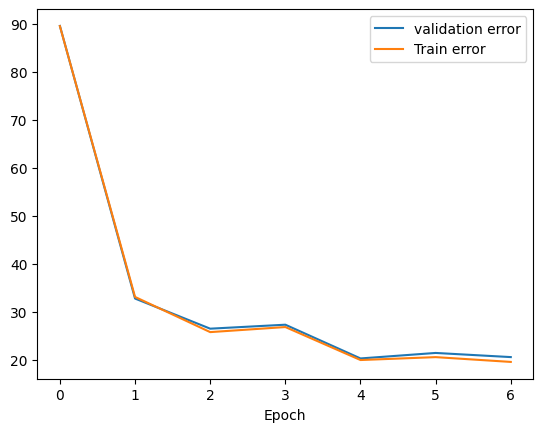

Epoch [8/100], Loss: 2.7557
Train Accuracy: 81.51%
Test Accuracy: 80.91%
Variance to keep :  0.49165094496213607  number of components :  3
[30.173871180706243, 3.738133341550897, 4.169588514691454, 2.2940561276712494, 2.126468509374429, 2.97799409739451, 5.222482064279941, 3.588706593976899]


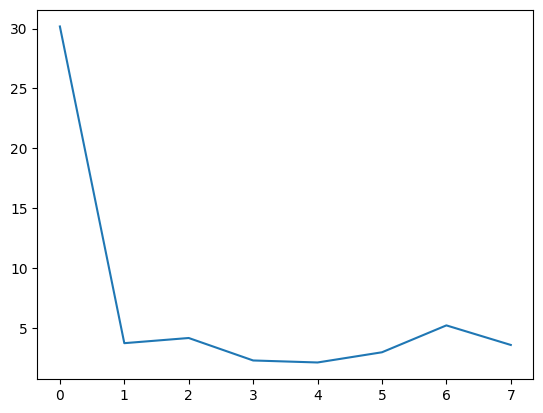

11.898309480493607
14.991660397930847
-0.41934919357299805
-0.4113032817840576
-0.4088020324707031
-0.40567708015441895
-0.40357327461242676
Chi-Square score:  1
Repley's K:  (803.0516363083999, 20.703509553692772)


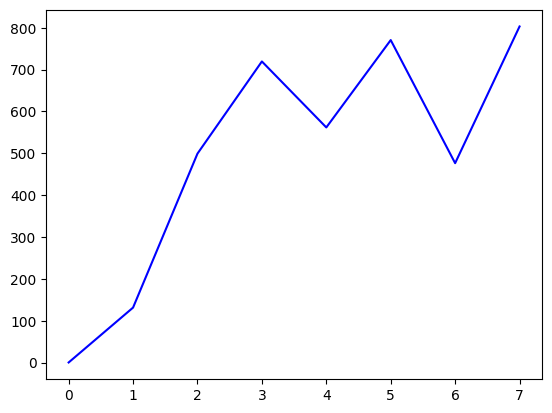

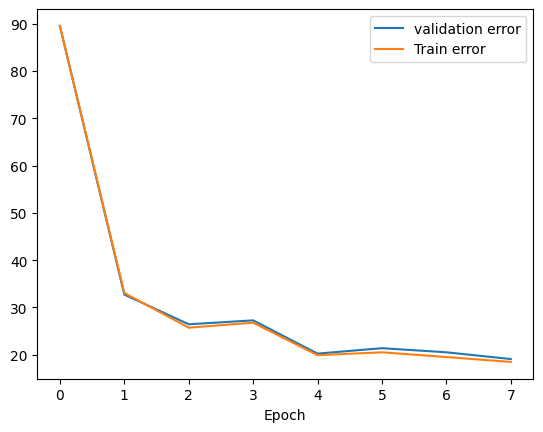

Epoch [9/100], Loss: 2.6198
Train Accuracy: 84.08%
Test Accuracy: 82.63%
Variance to keep :  0.4740139476214617  number of components :  3
[30.173871180706243, 3.738133341550897, 4.169588514691454, 2.2940561276712494, 2.126468509374429, 2.97799409739451, 5.222482064279941, 3.588706593976899, 2.4553639152229088]


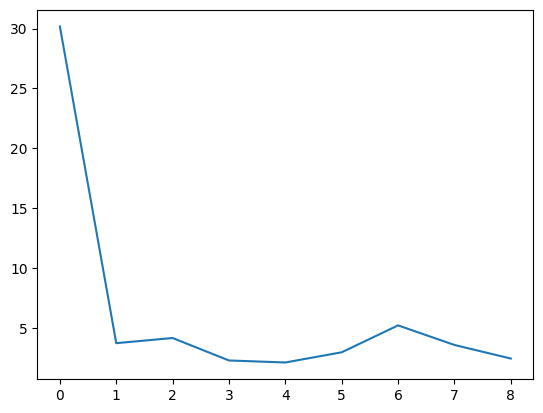

12.65043268772229
15.10226014339596
-0.3765134811401367
-0.37755632400512695
-0.3799772262573242
-0.3824479579925537
-0.3782827854156494
Chi-Square score:  1
Repley's K:  (957.8690882925879, 23.892897227822466)


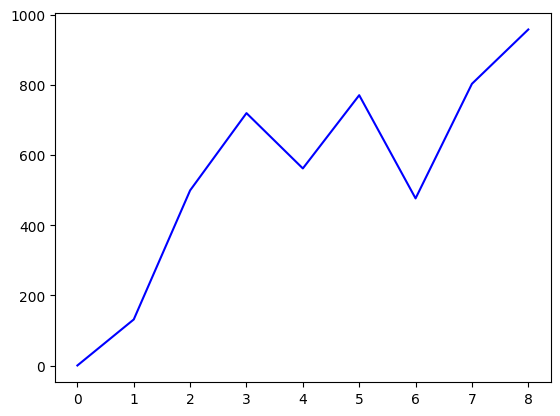

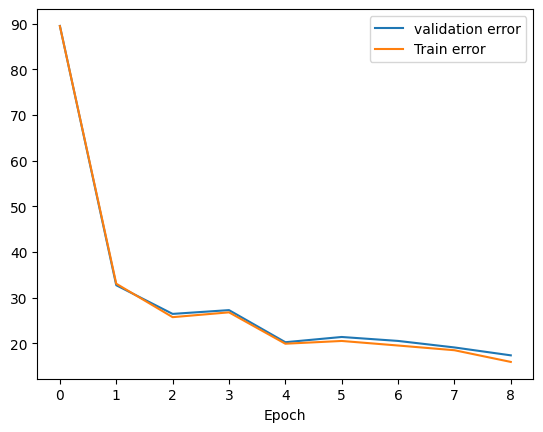

Epoch [10/100], Loss: 2.6316
Train Accuracy: 84.27%
Test Accuracy: 82.18%
Variance to keep :  0.47942673563423993  number of components :  3
[30.173871180706243, 3.738133341550897, 4.169588514691454, 2.2940561276712494, 2.126468509374429, 2.97799409739451, 5.222482064279941, 3.588706593976899, 2.4553639152229088, 2.007984798531697]


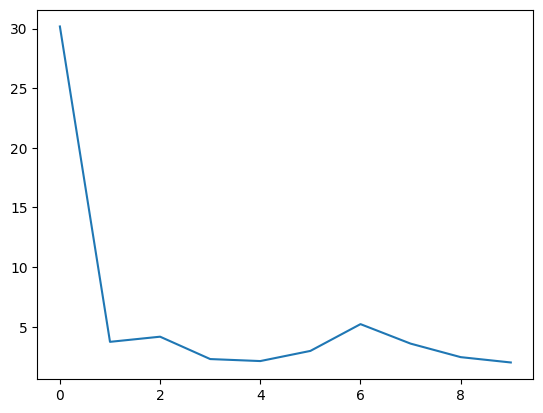

13.976772104047074
15.725396869759672
-0.40982794761657715
-0.39965105056762695
-0.40677595138549805
-0.411024808883667
-0.40816426277160645
Chi-Square score:  1
Repley's K:  (467.17916796401937, 18.340791787271648)


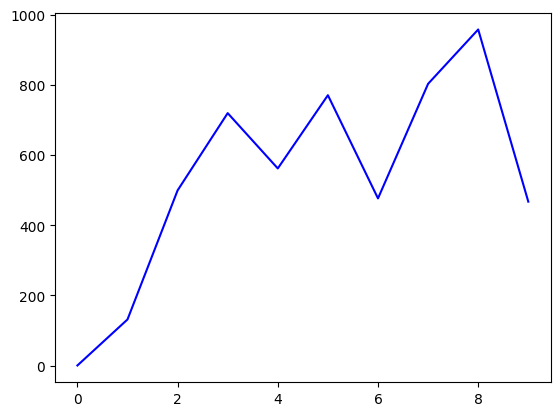

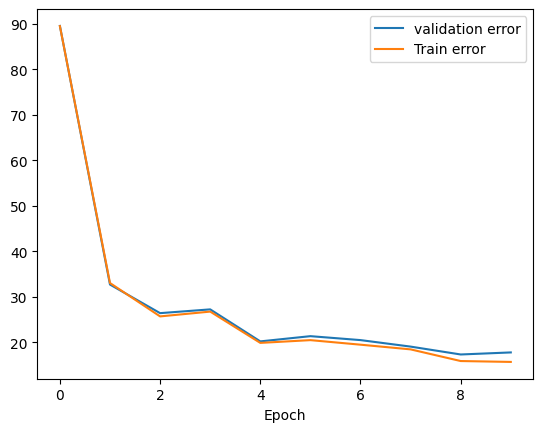

Epoch [11/100], Loss: 2.4806
Train Accuracy: 84.30%
Test Accuracy: 81.86%
Variance to keep :  0.464590782724578  number of components :  3
[30.173871180706243, 3.738133341550897, 4.169588514691454, 2.2940561276712494, 2.126468509374429, 2.97799409739451, 5.222482064279941, 3.588706593976899, 2.4553639152229088, 2.007984798531697, 1.62115138223387]


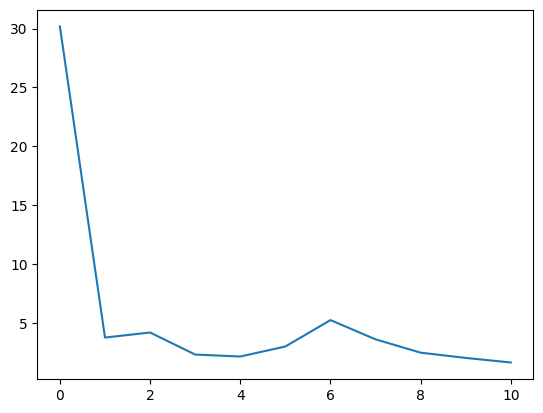

13.880151600574017
15.023497598792218
-0.4104788303375244
-0.41470956802368164
-0.42399120330810547
-0.41917991638183594
-0.41718554496765137
Chi-Square score:  1
Repley's K:  (377.8056989736407, 11.629399845644224)


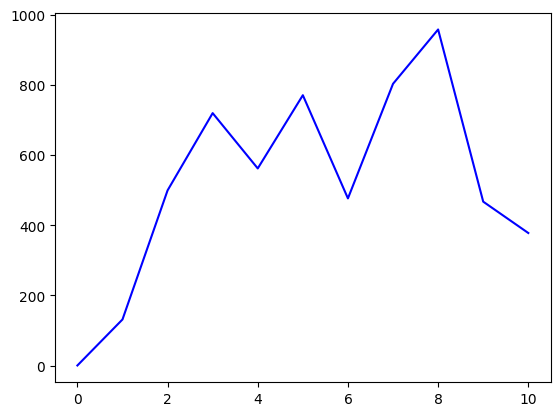

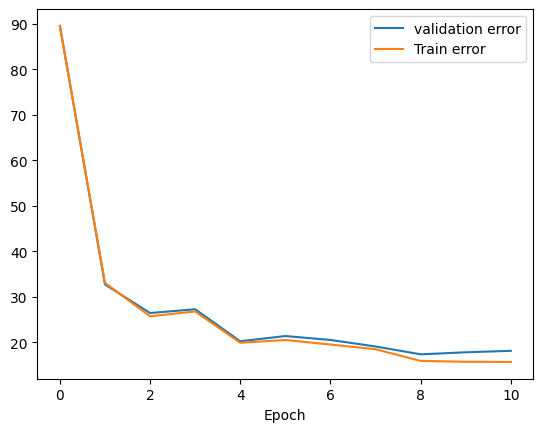

Epoch [12/100], Loss: 2.4294
Train Accuracy: 84.12%
Test Accuracy: 82.37%
Variance to keep :  0.4915596377189829  number of components :  3
[30.173871180706243, 3.738133341550897, 4.169588514691454, 2.2940561276712494, 2.126468509374429, 2.97799409739451, 5.222482064279941, 3.588706593976899, 2.4553639152229088, 2.007984798531697, 1.62115138223387, 2.247434907883317]


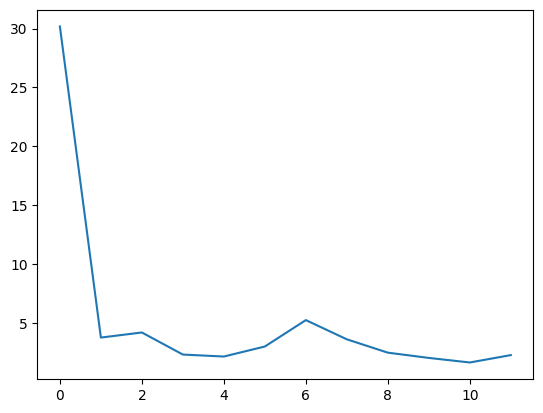

14.789850388914822
15.554314631989492
-0.4293551445007324
-0.42253851890563965
-0.42136311531066895
-0.42435693740844727
-0.42750120162963867
Chi-Square score:  1
Repley's K:  (452.0714324273151, 13.364420112925648)


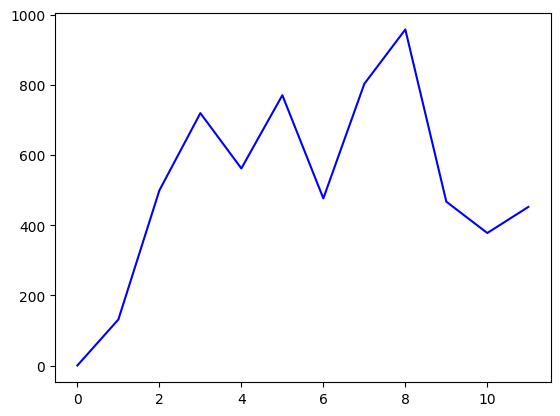

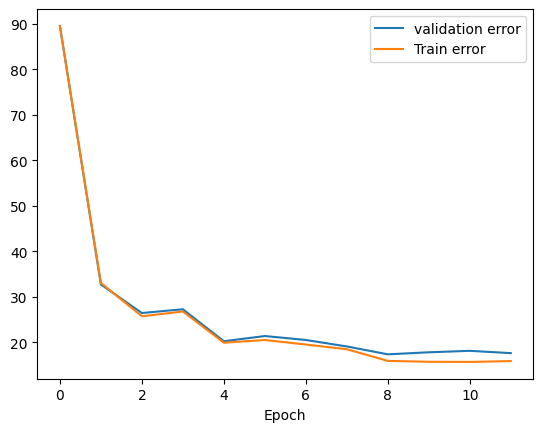

Epoch [13/100], Loss: 2.3593
Train Accuracy: 86.02%
Test Accuracy: 83.29%
Variance to keep :  0.4723809587017468  number of components :  3
[30.173871180706243, 3.738133341550897, 4.169588514691454, 2.2940561276712494, 2.126468509374429, 2.97799409739451, 5.222482064279941, 3.588706593976899, 2.4553639152229088, 2.007984798531697, 1.62115138223387, 2.247434907883317, 2.2485094373376966]


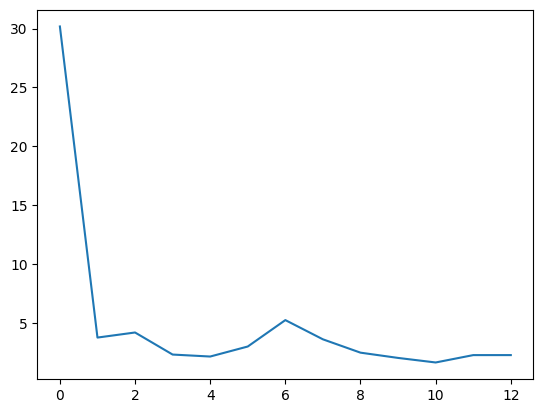

14.188298032868339
14.849757081184508
-0.4083890914916992
-0.406278133392334
-0.4103353023529053
-0.4082779884338379
-0.40946125984191895
Chi-Square score:  1
Repley's K:  (542.6315365253583, 14.983040444932808)


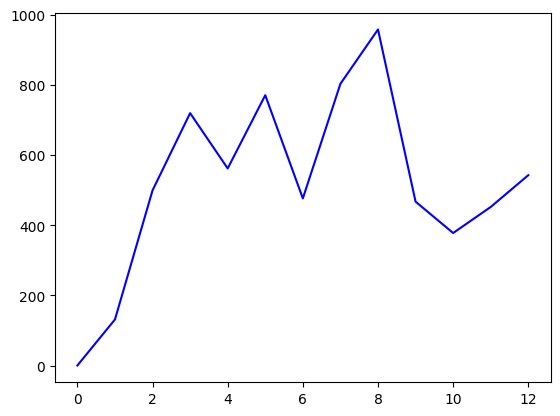

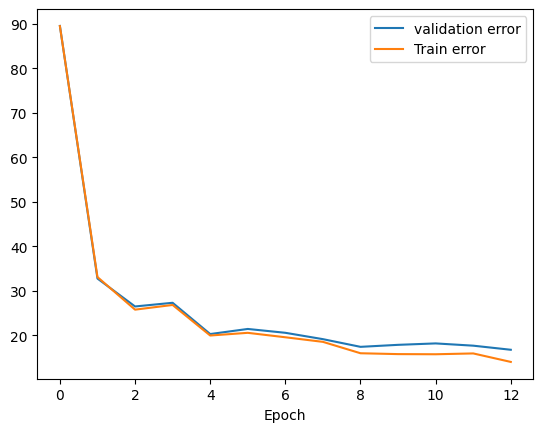

Epoch [14/100], Loss: 2.3110
Train Accuracy: 86.35%
Test Accuracy: 84.53%
Variance to keep :  0.46016502600582143  number of components :  3
[30.173871180706243, 3.738133341550897, 4.169588514691454, 2.2940561276712494, 2.126468509374429, 2.97799409739451, 5.222482064279941, 3.588706593976899, 2.4553639152229088, 2.007984798531697, 1.62115138223387, 2.247434907883317, 2.2485094373376966, 1.536786214992159]


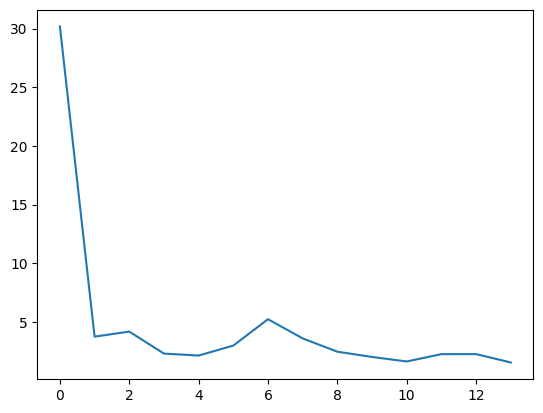

13.3689570068294
14.33147204174813
-0.46762728691101074
-0.45874857902526855
-0.456348180770874
-0.45949816703796387
-0.4575223922729492
Chi-Square score:  1
Repley's K:  (345.8619808754556, 18.17975334446938)


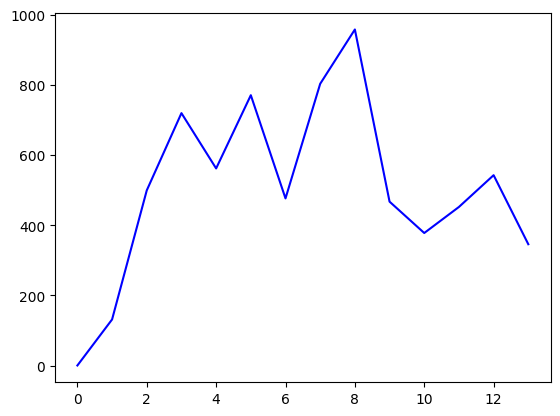

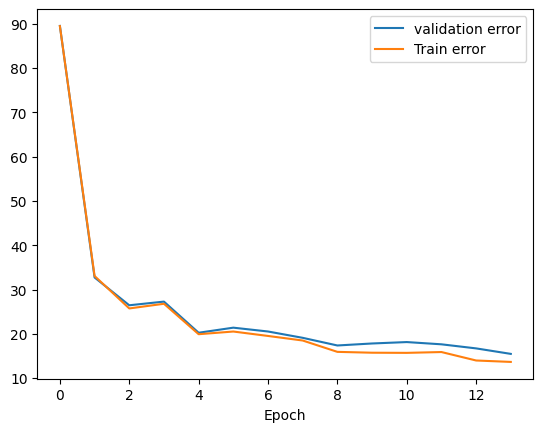

Epoch [15/100], Loss: 2.2416
Train Accuracy: 85.53%
Test Accuracy: 83.22%
Variance to keep :  0.4630582140816995  number of components :  3
[30.173871180706243, 3.738133341550897, 4.169588514691454, 2.2940561276712494, 2.126468509374429, 2.97799409739451, 5.222482064279941, 3.588706593976899, 2.4553639152229088, 2.007984798531697, 1.62115138223387, 2.247434907883317, 2.2485094373376966, 1.536786214992159, 2.125918621230803]


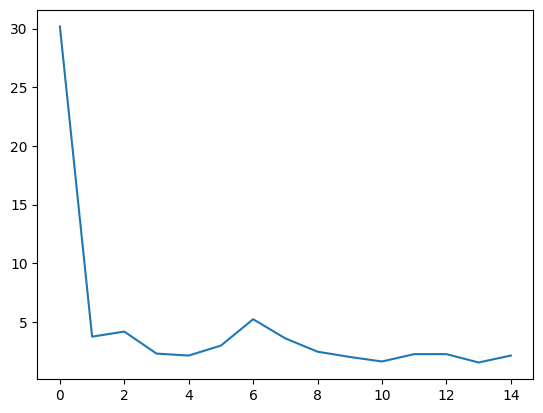

13.71855704210183
14.105182111757987
-0.4517247676849365
-0.4447488784790039
-0.44556736946105957
-0.4553194046020508
-0.45474934577941895
Chi-Square score:  1
Repley's K:  (566.1991869190481, 24.866500289353425)


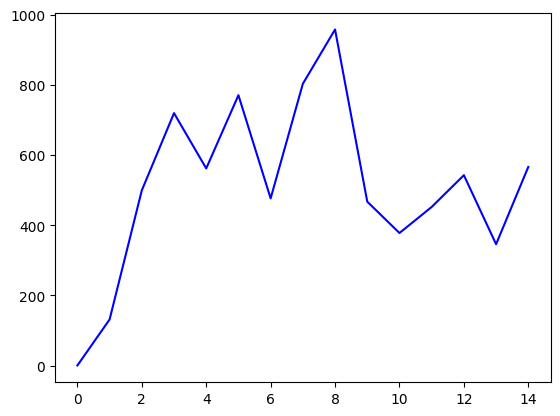

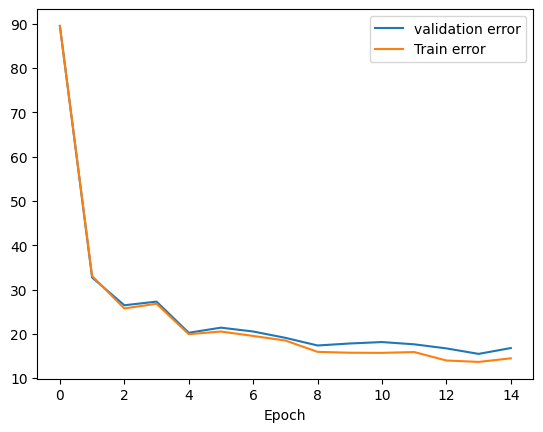

Epoch [16/100], Loss: 2.2281
Train Accuracy: 85.06%
Test Accuracy: 83.12%
Variance to keep :  0.48413175891357674  number of components :  3
[30.173871180706243, 3.738133341550897, 4.169588514691454, 2.2940561276712494, 2.126468509374429, 2.97799409739451, 5.222482064279941, 3.588706593976899, 2.4553639152229088, 2.007984798531697, 1.62115138223387, 2.247434907883317, 2.2485094373376966, 1.536786214992159, 2.125918621230803, 1.6088075615473532]


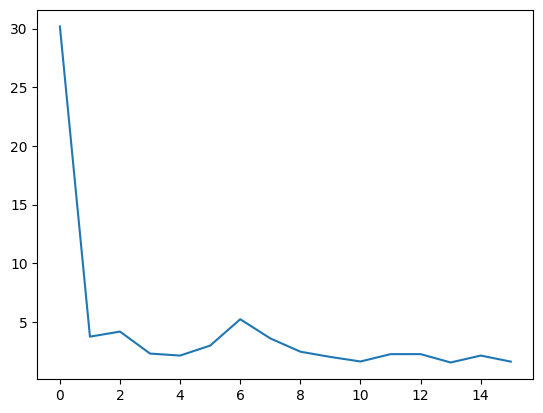

13.504407455217596
14.346706241751441
-0.4667997360229492
-0.4665658473968506
-0.4652106761932373
-0.4693484306335449
-0.46393632888793945
Chi-Square score:  1
Repley's K:  (419.07267091162015, 9.797093060990246)


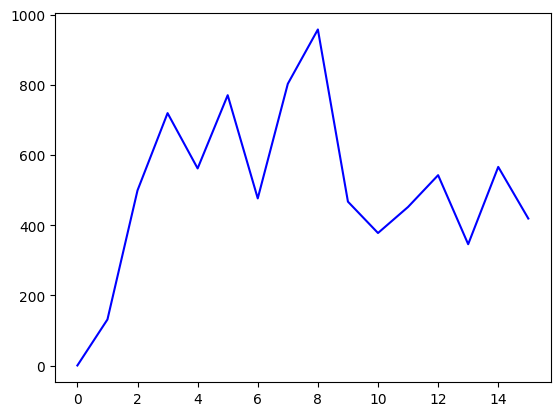

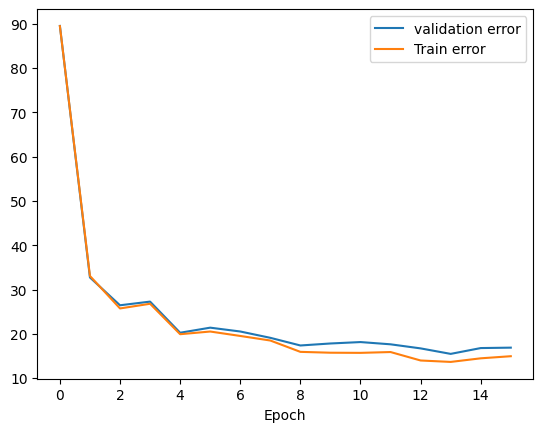

Epoch [17/100], Loss: 2.1722
Train Accuracy: 87.85%
Test Accuracy: 84.68%
Variance to keep :  0.47773825210947585  number of components :  3
[30.173871180706243, 3.738133341550897, 4.169588514691454, 2.2940561276712494, 2.126468509374429, 2.97799409739451, 5.222482064279941, 3.588706593976899, 2.4553639152229088, 2.007984798531697, 1.62115138223387, 2.247434907883317, 2.2485094373376966, 1.536786214992159, 2.125918621230803, 1.6088075615473532, 1.6295129267661719]


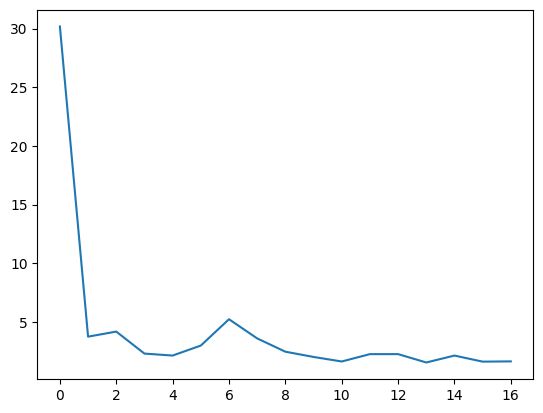

14.302353737082592
14.70101257638359
-0.45060062408447266
-0.4534897804260254
-0.4511146545410156
-0.46100592613220215
-0.45586657524108887
Chi-Square score:  1
Repley's K:  (285.2134309260495, 12.558037865439344)


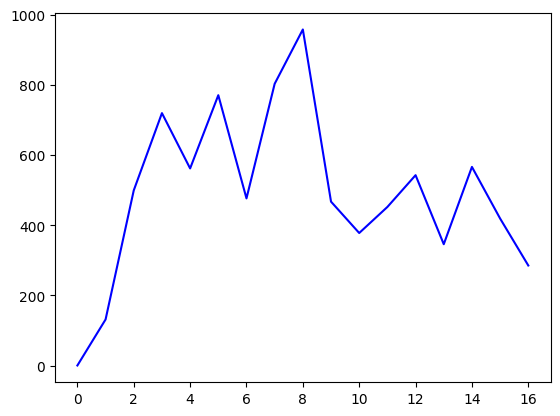

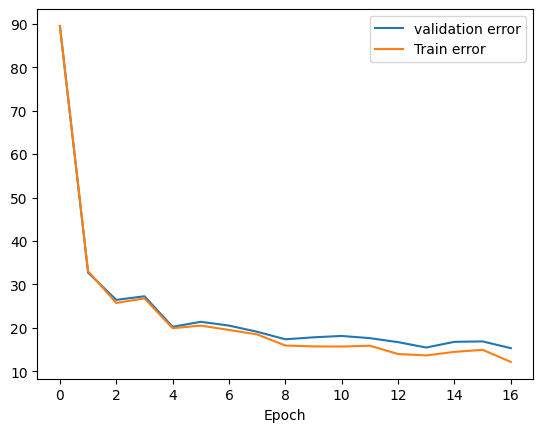

Epoch [18/100], Loss: 2.1446
Train Accuracy: 86.45%
Test Accuracy: 83.63%
Variance to keep :  0.48604870456464144  number of components :  3
[30.173871180706243, 3.738133341550897, 4.169588514691454, 2.2940561276712494, 2.126468509374429, 2.97799409739451, 5.222482064279941, 3.588706593976899, 2.4553639152229088, 2.007984798531697, 1.62115138223387, 2.247434907883317, 2.2485094373376966, 1.536786214992159, 2.125918621230803, 1.6088075615473532, 1.6295129267661719, 2.071675923722519]


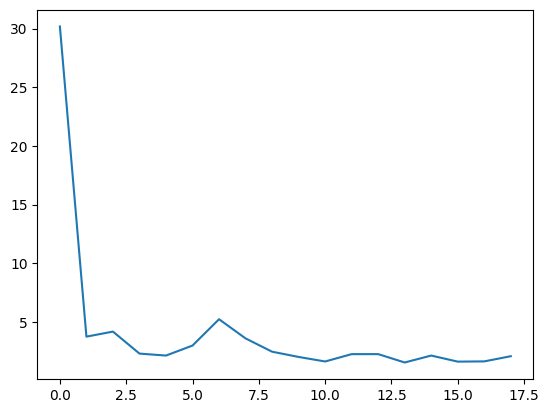

13.99450947739537
14.627201609697533
-0.48168325424194336
-0.4779348373413086
-0.48414039611816406
-0.4801342487335205
-0.4809598922729492
Chi-Square score:  1
Repley's K:  (262.5379010278249, 2.9610631866442754)


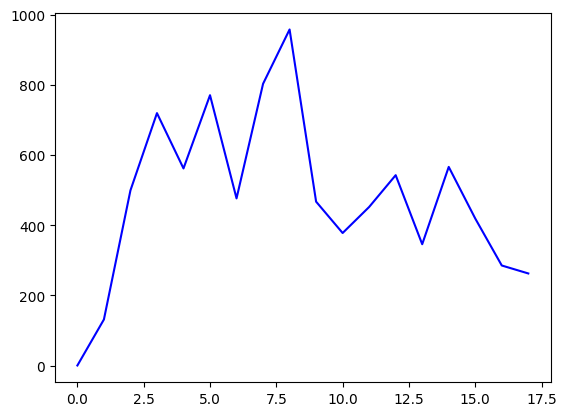

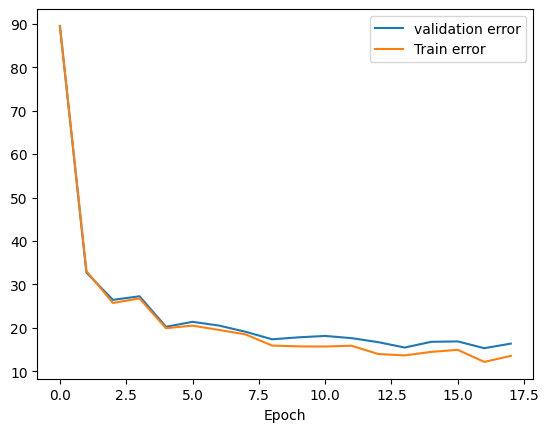

Epoch [19/100], Loss: 2.0926
Train Accuracy: 86.93%
Test Accuracy: 83.82%
Variance to keep :  0.4876999782289959  number of components :  3
[30.173871180706243, 3.738133341550897, 4.169588514691454, 2.2940561276712494, 2.126468509374429, 2.97799409739451, 5.222482064279941, 3.588706593976899, 2.4553639152229088, 2.007984798531697, 1.62115138223387, 2.247434907883317, 2.2485094373376966, 1.536786214992159, 2.125918621230803, 1.6088075615473532, 1.6295129267661719, 2.071675923722519, 1.790502582329297]


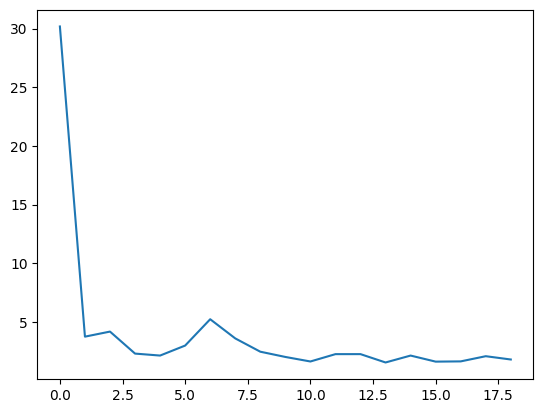

14.87707981142393
15.664685740686817
-0.47486066818237305
-0.47827720642089844
-0.4708535671234131
-0.4742577075958252
-0.4717390537261963
Chi-Square score:  1
Repley's K:  (219.2939081380445, 5.31806746045292)


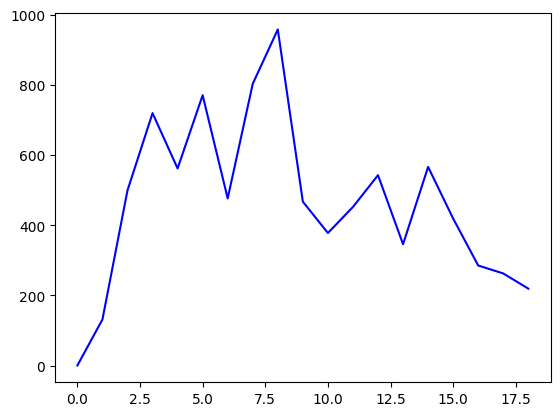

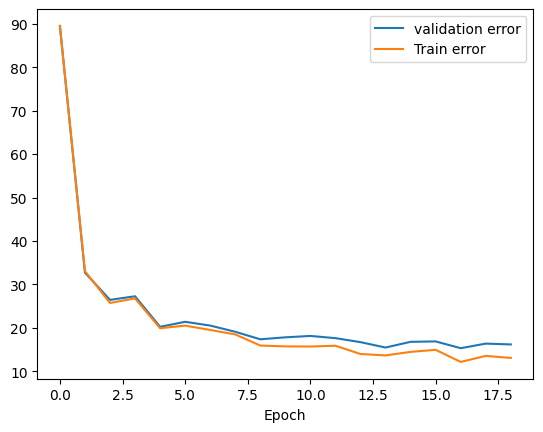

Epoch [20/100], Loss: 2.1064
Train Accuracy: 87.34%
Test Accuracy: 83.50%
Variance to keep :  0.49807614354877516  number of components :  3
[30.173871180706243, 3.738133341550897, 4.169588514691454, 2.2940561276712494, 2.126468509374429, 2.97799409739451, 5.222482064279941, 3.588706593976899, 2.4553639152229088, 2.007984798531697, 1.62115138223387, 2.247434907883317, 2.2485094373376966, 1.536786214992159, 2.125918621230803, 1.6088075615473532, 1.6295129267661719, 2.071675923722519, 1.790502582329297, 1.7437192117612774]


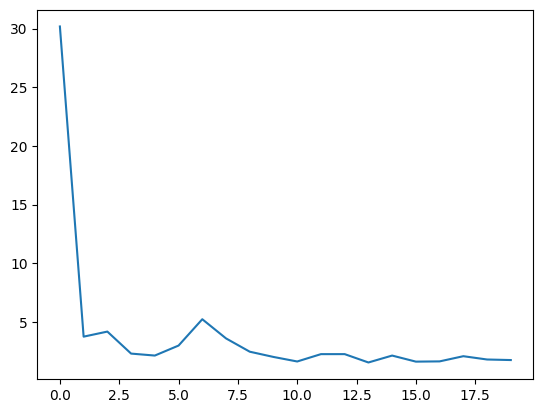

14.194284472955475
14.864178728810227
-0.4865987300872803
-0.4887731075286865
-0.4878537654876709
-0.4943113327026367
-0.49138617515563965
Chi-Square score:  1
Repley's K:  (213.6698278504784, 12.51110740974046)


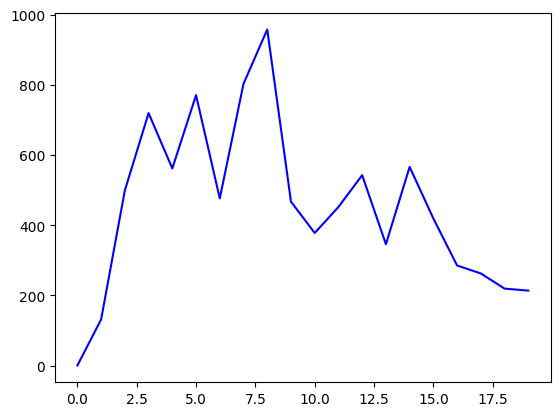

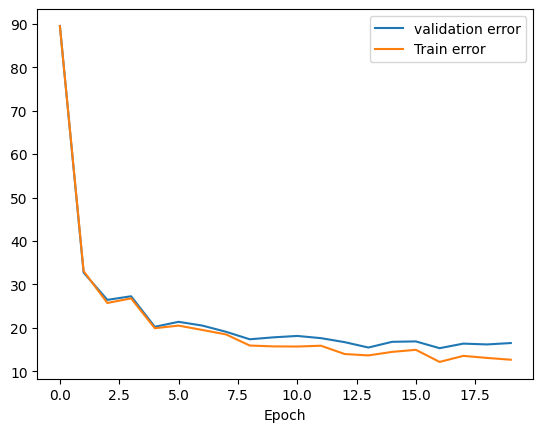

Epoch [21/100], Loss: 2.0275
Train Accuracy: 86.27%
Test Accuracy: 82.37%
Variance to keep :  0.5008931581055396  number of components :  3
[30.173871180706243, 3.738133341550897, 4.169588514691454, 2.2940561276712494, 2.126468509374429, 2.97799409739451, 5.222482064279941, 3.588706593976899, 2.4553639152229088, 2.007984798531697, 1.62115138223387, 2.247434907883317, 2.2485094373376966, 1.536786214992159, 2.125918621230803, 1.6088075615473532, 1.6295129267661719, 2.071675923722519, 1.790502582329297, 1.7437192117612774, 1.8197687968138745]


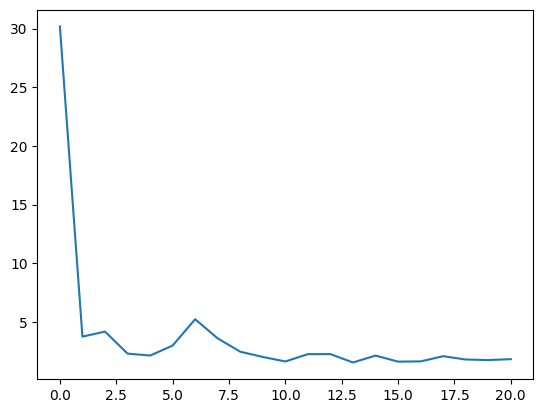

14.328449193009986
16.191261132383964
-0.48850488662719727
-0.48694849014282227
-0.48659253120422363
-0.4919257164001465
-0.49072885513305664
Chi-Square score:  1
Repley's K:  (195.43671874561073, 6.118740008273977)


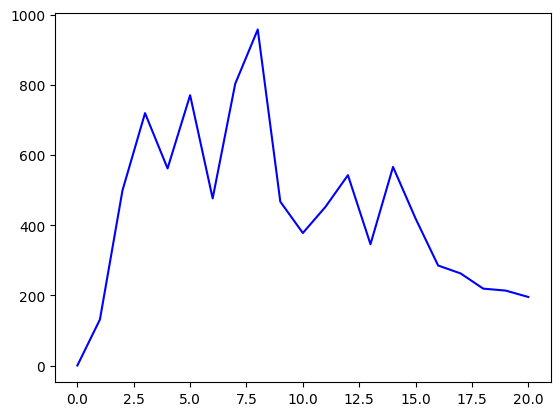

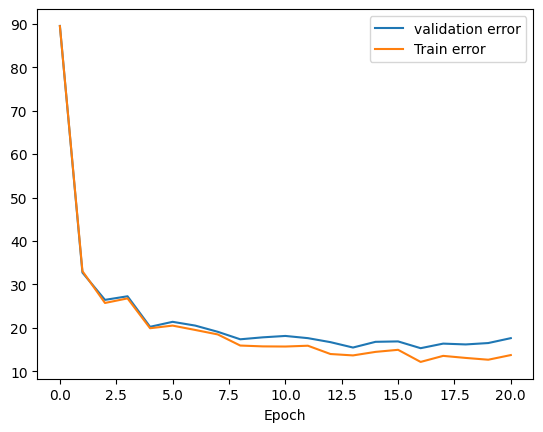

Epoch [22/100], Loss: 1.9895
Train Accuracy: 88.00%
Test Accuracy: 83.91%
Variance to keep :  0.4892658555039414  number of components :  3
[30.173871180706243, 3.738133341550897, 4.169588514691454, 2.2940561276712494, 2.126468509374429, 2.97799409739451, 5.222482064279941, 3.588706593976899, 2.4553639152229088, 2.007984798531697, 1.62115138223387, 2.247434907883317, 2.2485094373376966, 1.536786214992159, 2.125918621230803, 1.6088075615473532, 1.6295129267661719, 2.071675923722519, 1.790502582329297, 1.7437192117612774, 1.8197687968138745, 2.0292338566191734]


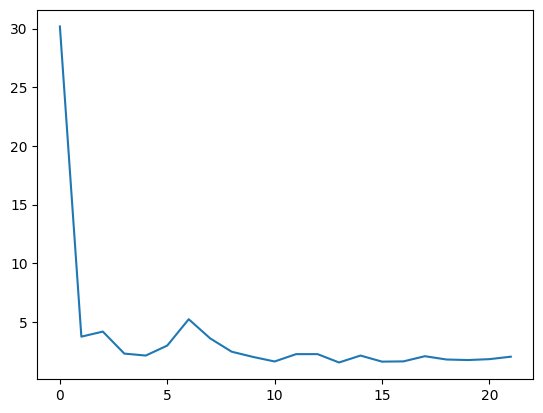

14.924929768138302
15.347692146005441
-0.4789888858795166
-0.4834916591644287
-0.4856739044189453
-0.4854614734649658
-0.47356605529785156
Chi-Square score:  1
Repley's K:  (233.9898609576065, 13.653826340609132)


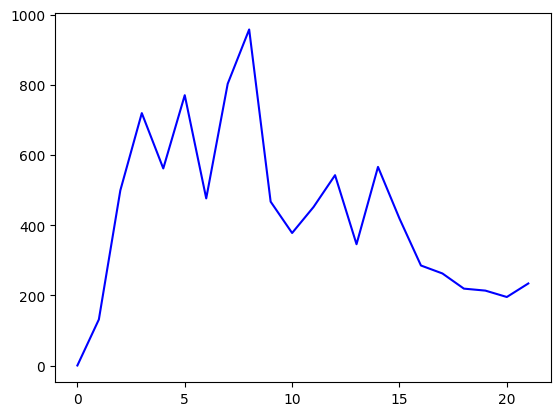

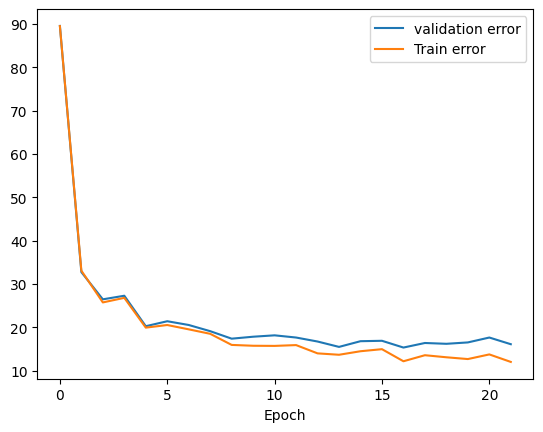

Epoch [23/100], Loss: 2.0327
Train Accuracy: 88.23%
Test Accuracy: 84.06%
Variance to keep :  0.5052635519879561  number of components :  3
[30.173871180706243, 3.738133341550897, 4.169588514691454, 2.2940561276712494, 2.126468509374429, 2.97799409739451, 5.222482064279941, 3.588706593976899, 2.4553639152229088, 2.007984798531697, 1.62115138223387, 2.247434907883317, 2.2485094373376966, 1.536786214992159, 2.125918621230803, 1.6088075615473532, 1.6295129267661719, 2.071675923722519, 1.790502582329297, 1.7437192117612774, 1.8197687968138745, 2.0292338566191734, 1.9170648058008848]


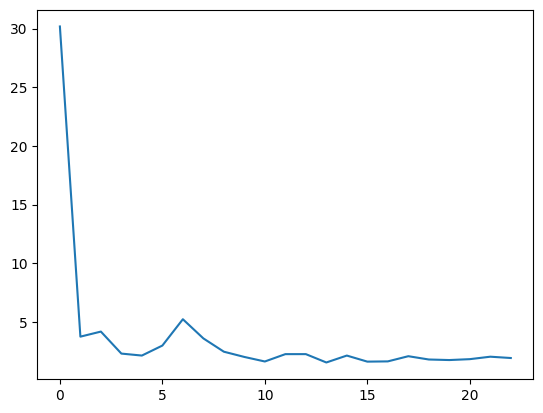

15.543599096444146
16.04909952319914
-0.4836692810058594
-0.47477078437805176
-0.48032116889953613
-0.4707934856414795
-0.47583556175231934
Chi-Square score:  1
Repley's K:  (178.97087454558041, 7.986391205895766)


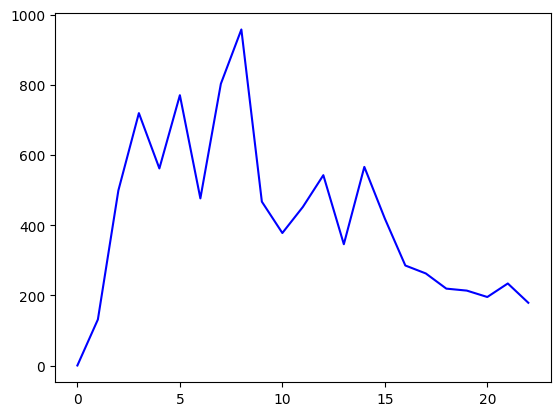

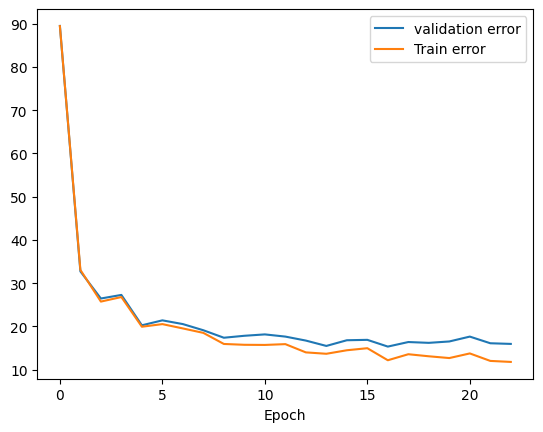

Variance to keep :  0.4996211505597464  number of components :  3
[30.173871180706243, 3.738133341550897, 4.169588514691454, 2.2940561276712494, 2.126468509374429, 2.97799409739451, 5.222482064279941, 3.588706593976899, 2.4553639152229088, 2.007984798531697, 1.62115138223387, 2.247434907883317, 2.2485094373376966, 1.536786214992159, 2.125918621230803, 1.6088075615473532, 1.6295129267661719, 2.071675923722519, 1.790502582329297, 1.7437192117612774, 1.8197687968138745, 2.0292338566191734, 1.9170648058008848, 2.0750796715538895]


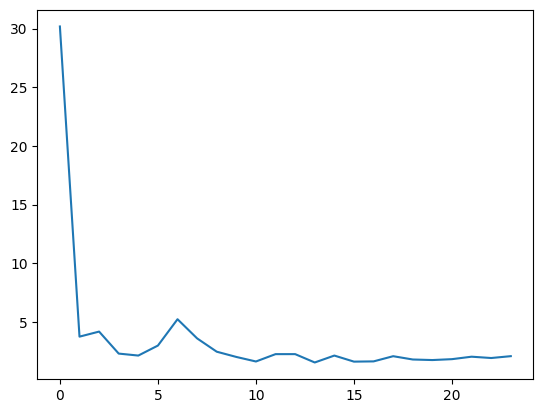

14.820628579053578
15.388123679503
-0.4993400573730469
-0.4906320571899414
-0.4943680763244629
-0.5041983127593994
-0.4954967498779297
Chi-Square score:  1
Repley's K:  (190.71131769982335, 7.9885013787155605)


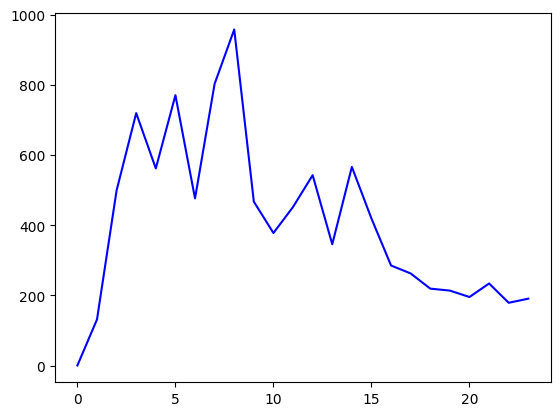

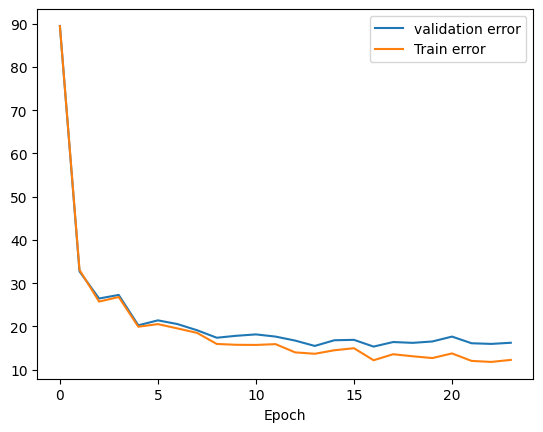

Epoch [25/100], Loss: 1.9456
Train Accuracy: 88.83%
Test Accuracy: 84.81%
Variance to keep :  0.4973902785717136  number of components :  3
[30.173871180706243, 3.738133341550897, 4.169588514691454, 2.2940561276712494, 2.126468509374429, 2.97799409739451, 5.222482064279941, 3.588706593976899, 2.4553639152229088, 2.007984798531697, 1.62115138223387, 2.247434907883317, 2.2485094373376966, 1.536786214992159, 2.125918621230803, 1.6088075615473532, 1.6295129267661719, 2.071675923722519, 1.790502582329297, 1.7437192117612774, 1.8197687968138745, 2.0292338566191734, 1.9170648058008848, 2.0750796715538895, 1.84692541837599]


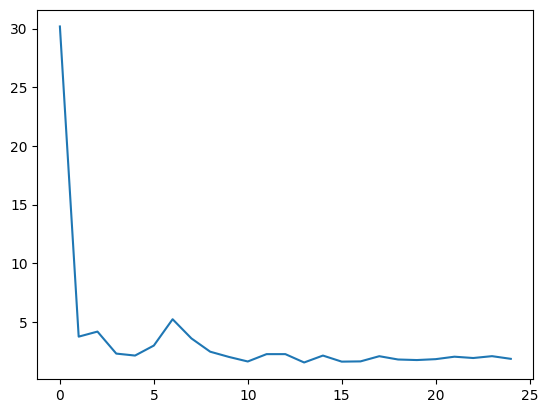

15.680721571204067
16.399728195742973
-0.4953463077545166
-0.4968585968017578
-0.48999905586242676
-0.500654935836792
-0.4894850254058838
Chi-Square score:  1
Repley's K:  (216.6246755636777, 11.76382954743743)


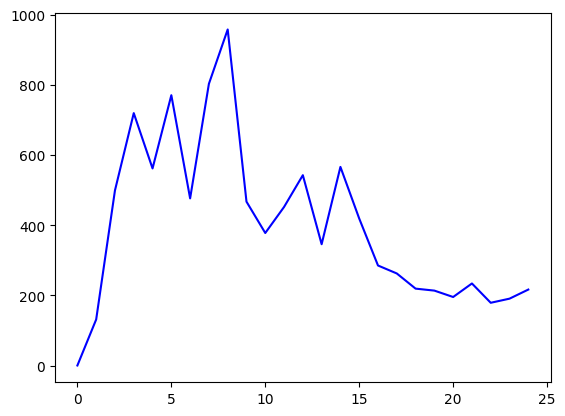

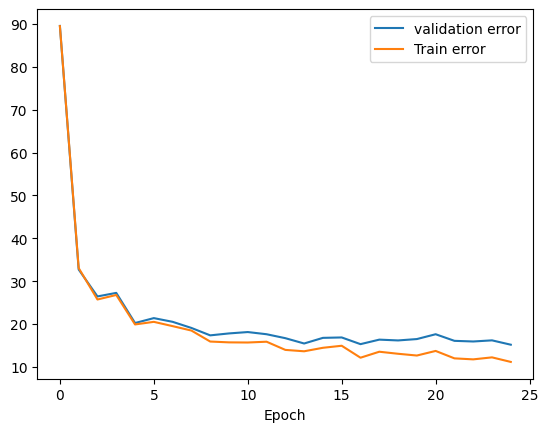

Epoch [26/100], Loss: 1.9623
Train Accuracy: 88.71%
Test Accuracy: 84.63%
Variance to keep :  0.49300785508672645  number of components :  3
[30.173871180706243, 3.738133341550897, 4.169588514691454, 2.2940561276712494, 2.126468509374429, 2.97799409739451, 5.222482064279941, 3.588706593976899, 2.4553639152229088, 2.007984798531697, 1.62115138223387, 2.247434907883317, 2.2485094373376966, 1.536786214992159, 2.125918621230803, 1.6088075615473532, 1.6295129267661719, 2.071675923722519, 1.790502582329297, 1.7437192117612774, 1.8197687968138745, 2.0292338566191734, 1.9170648058008848, 2.0750796715538895, 1.84692541837599, 2.3074218787778684]


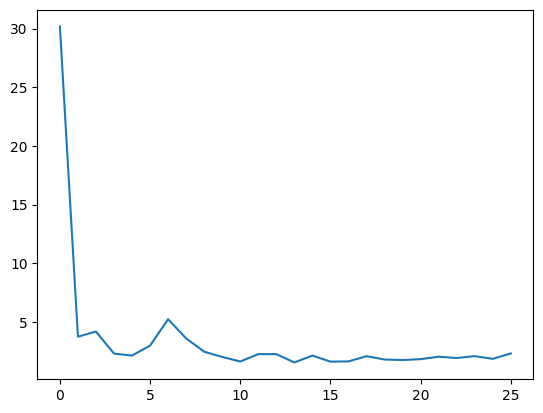

17.744303090649275
19.639891955087847
-0.46527671813964844
-0.4597599506378174
-0.457874059677124
-0.46460556983947754
-0.4603755474090576
Chi-Square score:  1
Repley's K:  (123.9556370356489, 3.43273183539202)


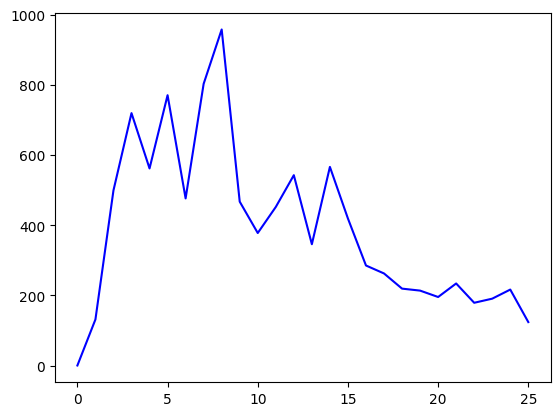

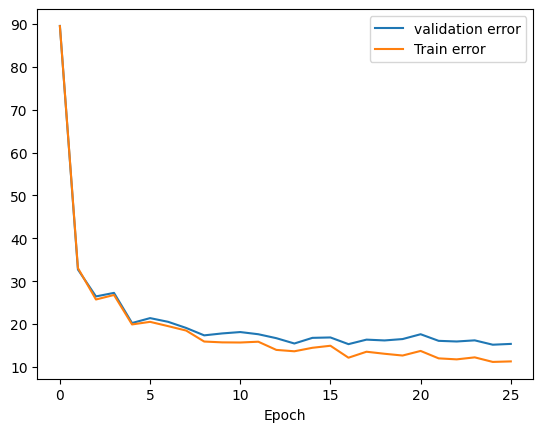

Epoch [27/100], Loss: 1.9490
Train Accuracy: 87.60%
Test Accuracy: 83.97%
Variance to keep :  0.5092907236576961  number of components :  3
[30.173871180706243, 3.738133341550897, 4.169588514691454, 2.2940561276712494, 2.126468509374429, 2.97799409739451, 5.222482064279941, 3.588706593976899, 2.4553639152229088, 2.007984798531697, 1.62115138223387, 2.247434907883317, 2.2485094373376966, 1.536786214992159, 2.125918621230803, 1.6088075615473532, 1.6295129267661719, 2.071675923722519, 1.790502582329297, 1.7437192117612774, 1.8197687968138745, 2.0292338566191734, 1.9170648058008848, 2.0750796715538895, 1.84692541837599, 2.3074218787778684, 1.6364008570301327]


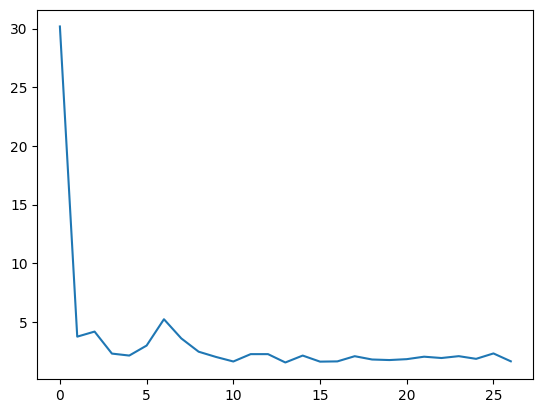

15.419752614017824
16.341751372686737
-0.5155375003814697
-0.5129406452178955
-0.5102899074554443
-0.5069830417633057
-0.5107386112213135
Chi-Square score:  1
Repley's K:  (95.20019184416338, 2.7184407322273736)


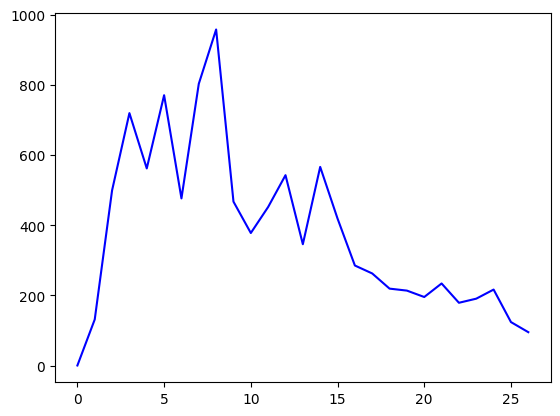

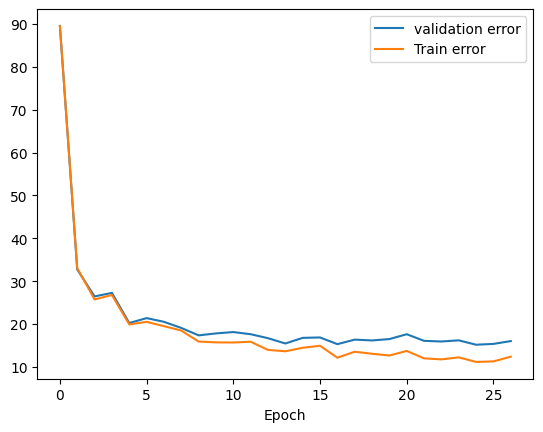

Epoch [28/100], Loss: 1.9079
Train Accuracy: 88.58%
Test Accuracy: 82.86%
Variance to keep :  0.4935818454190807  number of components :  3
[30.173871180706243, 3.738133341550897, 4.169588514691454, 2.2940561276712494, 2.126468509374429, 2.97799409739451, 5.222482064279941, 3.588706593976899, 2.4553639152229088, 2.007984798531697, 1.62115138223387, 2.247434907883317, 2.2485094373376966, 1.536786214992159, 2.125918621230803, 1.6088075615473532, 1.6295129267661719, 2.071675923722519, 1.790502582329297, 1.7437192117612774, 1.8197687968138745, 2.0292338566191734, 1.9170648058008848, 2.0750796715538895, 1.84692541837599, 2.3074218787778684, 1.6364008570301327, 1.454098178304164]


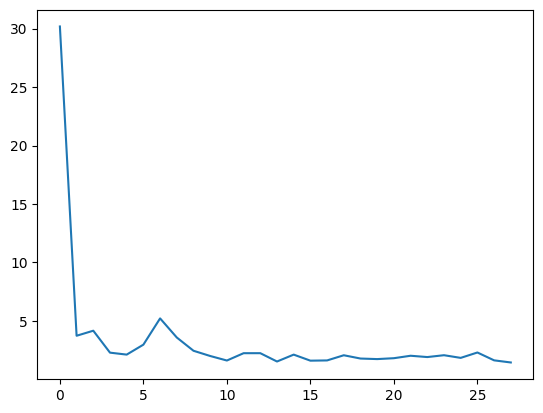

15.165624283051063
16.5134140307866
-0.5417056083679199
-0.539276123046875
-0.5430402755737305
-0.5410032272338867
-0.5440173149108887
Chi-Square score:  1
Repley's K:  (57.53126637398705, 2.5054989258978755)


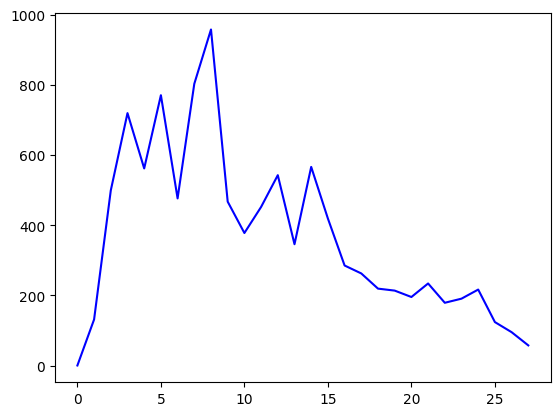

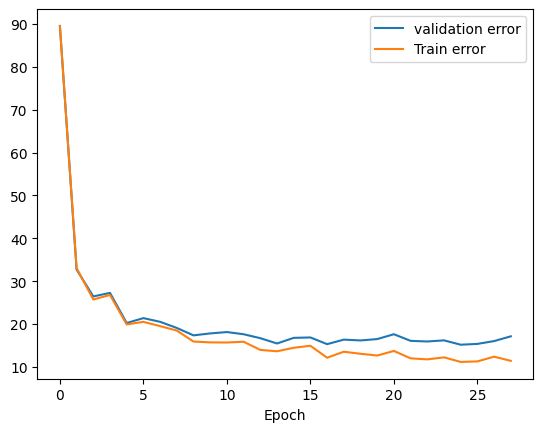

Epoch [29/100], Loss: 1.8838
Train Accuracy: 89.35%
Test Accuracy: 84.57%
Variance to keep :  0.5110170383291774  number of components :  3
[30.173871180706243, 3.738133341550897, 4.169588514691454, 2.2940561276712494, 2.126468509374429, 2.97799409739451, 5.222482064279941, 3.588706593976899, 2.4553639152229088, 2.007984798531697, 1.62115138223387, 2.247434907883317, 2.2485094373376966, 1.536786214992159, 2.125918621230803, 1.6088075615473532, 1.6295129267661719, 2.071675923722519, 1.790502582329297, 1.7437192117612774, 1.8197687968138745, 2.0292338566191734, 1.9170648058008848, 2.0750796715538895, 1.84692541837599, 2.3074218787778684, 1.6364008570301327, 1.454098178304164, 2.029749688199856]


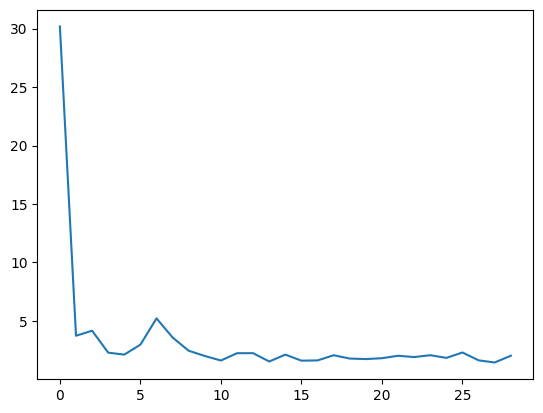

15.58684230903215
16.463946266665452
-0.5223133563995361
-0.5148327350616455
-0.516136884689331
-0.517784833908081
-0.5165660381317139
Chi-Square score:  1
Repley's K:  (85.3023323402181, 3.3119721832209708)


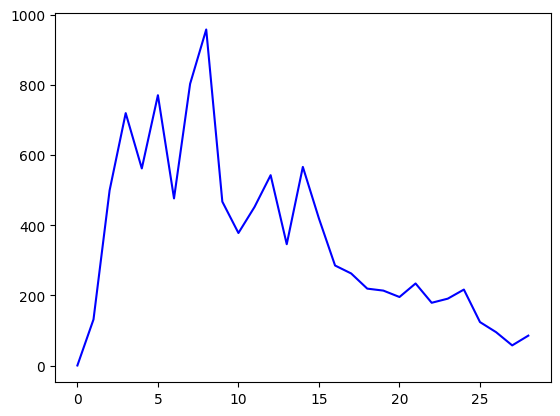

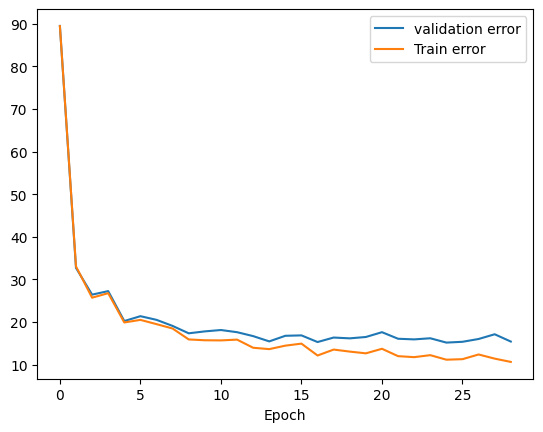

Epoch [30/100], Loss: 1.8818
Train Accuracy: 89.32%
Test Accuracy: 84.33%
Variance to keep :  0.509094683248523  number of components :  3
[30.173871180706243, 3.738133341550897, 4.169588514691454, 2.2940561276712494, 2.126468509374429, 2.97799409739451, 5.222482064279941, 3.588706593976899, 2.4553639152229088, 2.007984798531697, 1.62115138223387, 2.247434907883317, 2.2485094373376966, 1.536786214992159, 2.125918621230803, 1.6088075615473532, 1.6295129267661719, 2.071675923722519, 1.790502582329297, 1.7437192117612774, 1.8197687968138745, 2.0292338566191734, 1.9170648058008848, 2.0750796715538895, 1.84692541837599, 2.3074218787778684, 1.6364008570301327, 1.454098178304164, 2.029749688199856, 1.6527796581386283]


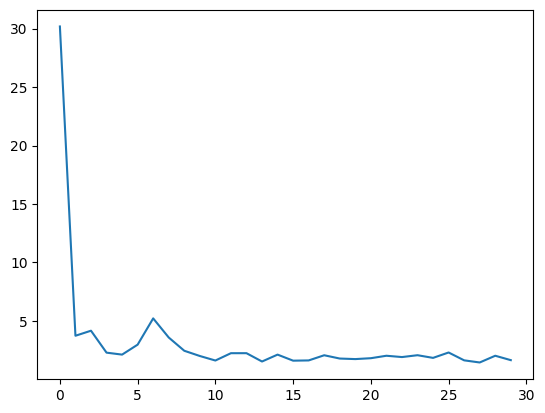

15.497689576496937
16.630190021335643
-0.5211319923400879
-0.5178403854370117
-0.519503116607666
-0.5240740776062012
-0.5218074321746826
Chi-Square score:  1
Repley's K:  (122.76813594013719, 4.471982021611963)


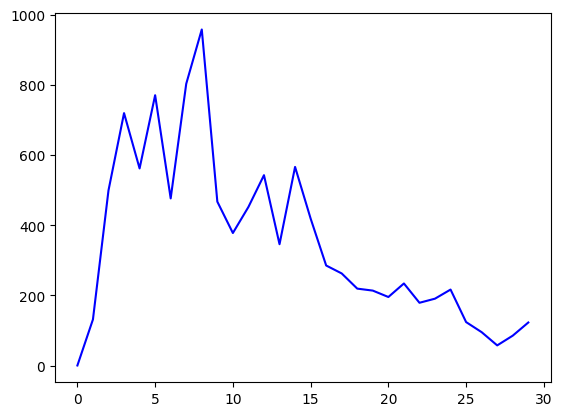

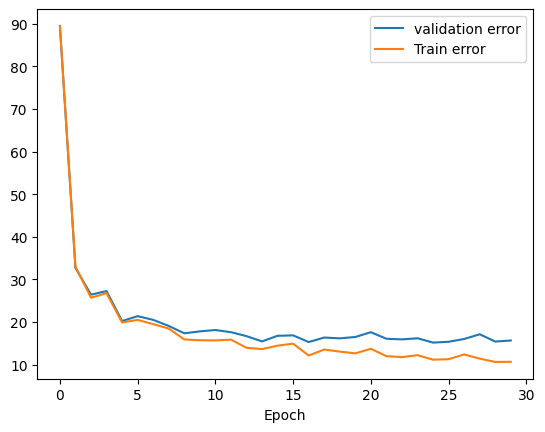

Epoch [31/100], Loss: 1.8215
Train Accuracy: 88.88%
Test Accuracy: 84.12%
Variance to keep :  0.508118213432622  number of components :  3
[30.173871180706243, 3.738133341550897, 4.169588514691454, 2.2940561276712494, 2.126468509374429, 2.97799409739451, 5.222482064279941, 3.588706593976899, 2.4553639152229088, 2.007984798531697, 1.62115138223387, 2.247434907883317, 2.2485094373376966, 1.536786214992159, 2.125918621230803, 1.6088075615473532, 1.6295129267661719, 2.071675923722519, 1.790502582329297, 1.7437192117612774, 1.8197687968138745, 2.0292338566191734, 1.9170648058008848, 2.0750796715538895, 1.84692541837599, 2.3074218787778684, 1.6364008570301327, 1.454098178304164, 2.029749688199856, 1.6527796581386283, 3.8562605498242633]


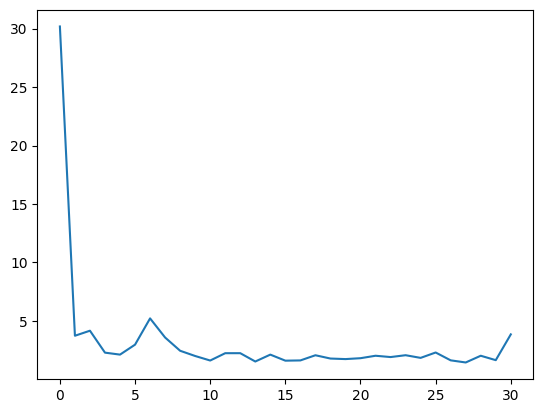

15.23055988926585
16.625434309481328
-0.5213909149169922
-0.5240788459777832
-0.5257303714752197
-0.5193722248077393
-0.5230603218078613
Chi-Square score:  1
Repley's K:  (51.88033117008716, 3.89703937742868)


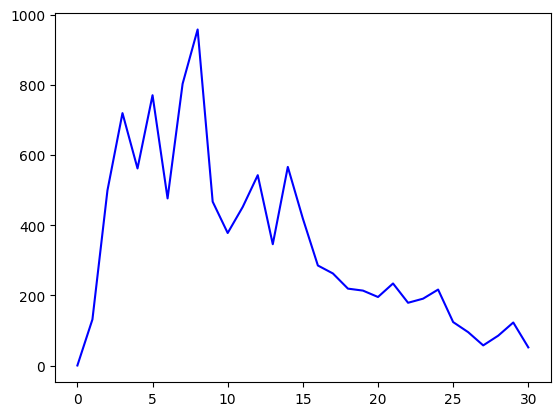

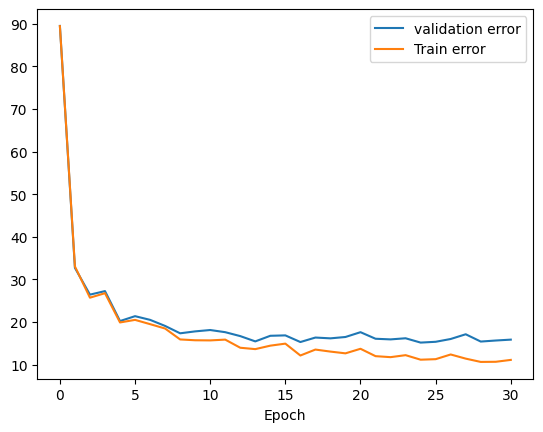

Epoch [32/100], Loss: 1.8822
Train Accuracy: 90.38%
Test Accuracy: 85.68%
Variance to keep :  0.5026391902144519  number of components :  3
[30.173871180706243, 3.738133341550897, 4.169588514691454, 2.2940561276712494, 2.126468509374429, 2.97799409739451, 5.222482064279941, 3.588706593976899, 2.4553639152229088, 2.007984798531697, 1.62115138223387, 2.247434907883317, 2.2485094373376966, 1.536786214992159, 2.125918621230803, 1.6088075615473532, 1.6295129267661719, 2.071675923722519, 1.790502582329297, 1.7437192117612774, 1.8197687968138745, 2.0292338566191734, 1.9170648058008848, 2.0750796715538895, 1.84692541837599, 2.3074218787778684, 1.6364008570301327, 1.454098178304164, 2.029749688199856, 1.6527796581386283, 3.8562605498242633, 1.731359723642224]


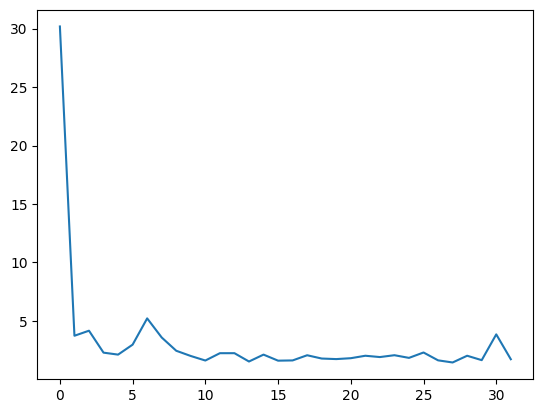

16.049357981696616
17.69596312377907
-0.5295529365539551
-0.5328295230865479
-0.5326039791107178
-0.5317447185516357
-0.5273153781890869
Chi-Square score:  1
Repley's K:  (58.42328701205507, 1.943128044409165)


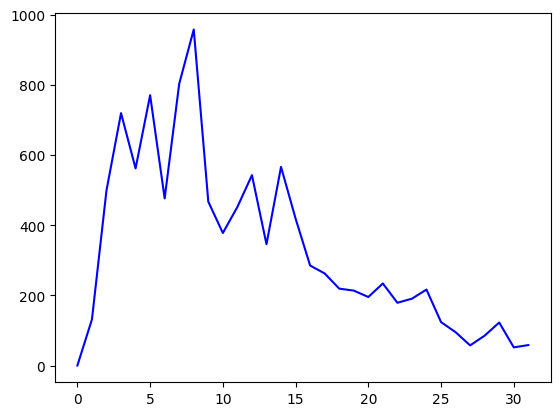

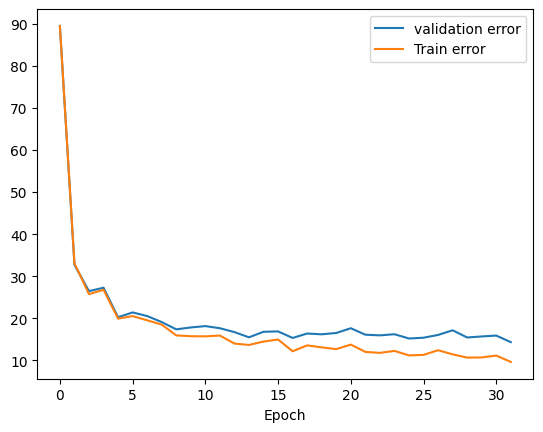

Epoch [33/100], Loss: 1.8454
Train Accuracy: 90.44%
Test Accuracy: 85.49%
Variance to keep :  0.5086710089008037  number of components :  3
[30.173871180706243, 3.738133341550897, 4.169588514691454, 2.2940561276712494, 2.126468509374429, 2.97799409739451, 5.222482064279941, 3.588706593976899, 2.4553639152229088, 2.007984798531697, 1.62115138223387, 2.247434907883317, 2.2485094373376966, 1.536786214992159, 2.125918621230803, 1.6088075615473532, 1.6295129267661719, 2.071675923722519, 1.790502582329297, 1.7437192117612774, 1.8197687968138745, 2.0292338566191734, 1.9170648058008848, 2.0750796715538895, 1.84692541837599, 2.3074218787778684, 1.6364008570301327, 1.454098178304164, 2.029749688199856, 1.6527796581386283, 3.8562605498242633, 1.731359723642224, 2.7444459599019715]


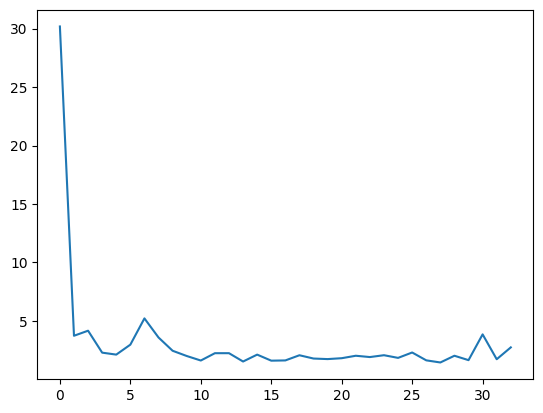

15.4703678570147
16.59590108836657
-0.5388283729553223
-0.5348584651947021
-0.5350737571716309
-0.5334532260894775
-0.5329749584197998
Chi-Square score:  1
Repley's K:  (50.021527862834354, 2.7429040965793967)


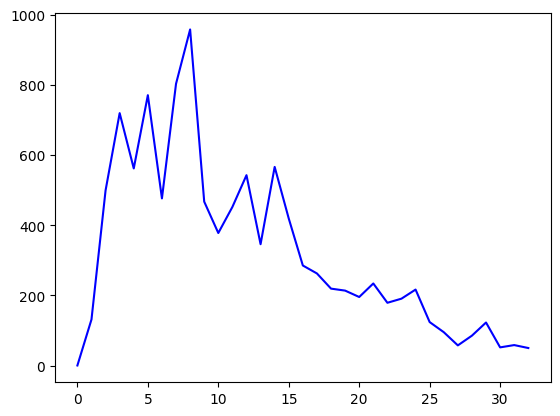

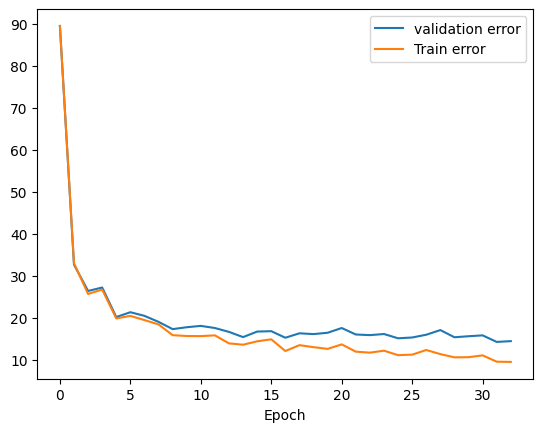

Epoch [34/100], Loss: 1.8544
Train Accuracy: 91.33%
Test Accuracy: 85.57%
Variance to keep :  0.506459574738744  number of components :  3
[30.173871180706243, 3.738133341550897, 4.169588514691454, 2.2940561276712494, 2.126468509374429, 2.97799409739451, 5.222482064279941, 3.588706593976899, 2.4553639152229088, 2.007984798531697, 1.62115138223387, 2.247434907883317, 2.2485094373376966, 1.536786214992159, 2.125918621230803, 1.6088075615473532, 1.6295129267661719, 2.071675923722519, 1.790502582329297, 1.7437192117612774, 1.8197687968138745, 2.0292338566191734, 1.9170648058008848, 2.0750796715538895, 1.84692541837599, 2.3074218787778684, 1.6364008570301327, 1.454098178304164, 2.029749688199856, 1.6527796581386283, 3.8562605498242633, 1.731359723642224, 2.7444459599019715, 1.9041492495152266]


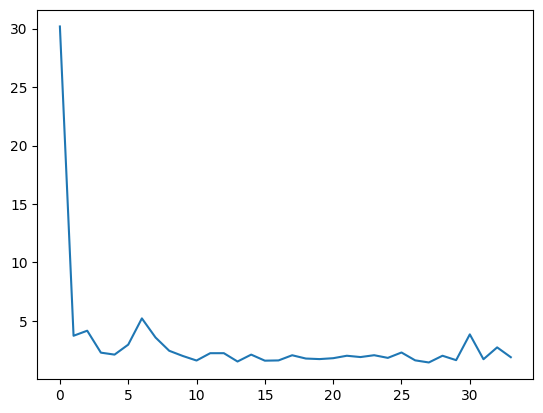

15.88834024008826
18.043573203589254
-0.5233783721923828
-0.5222043991088867
-0.5272502899169922
-0.5216870307922363
-0.5228500366210938
Chi-Square score:  1
Repley's K:  (61.04524299167511, 1.4524541222672673)


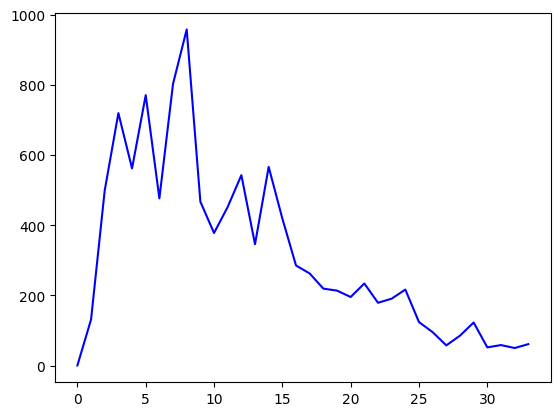

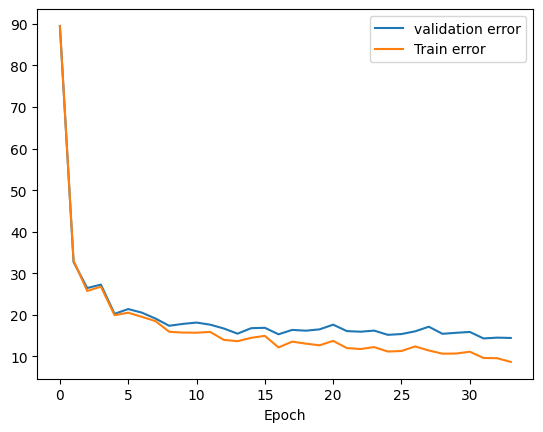

Epoch [35/100], Loss: 1.8412
Train Accuracy: 90.57%
Test Accuracy: 85.55%
Variance to keep :  0.5097222908873348  number of components :  3
[30.173871180706243, 3.738133341550897, 4.169588514691454, 2.2940561276712494, 2.126468509374429, 2.97799409739451, 5.222482064279941, 3.588706593976899, 2.4553639152229088, 2.007984798531697, 1.62115138223387, 2.247434907883317, 2.2485094373376966, 1.536786214992159, 2.125918621230803, 1.6088075615473532, 1.6295129267661719, 2.071675923722519, 1.790502582329297, 1.7437192117612774, 1.8197687968138745, 2.0292338566191734, 1.9170648058008848, 2.0750796715538895, 1.84692541837599, 2.3074218787778684, 1.6364008570301327, 1.454098178304164, 2.029749688199856, 1.6527796581386283, 3.8562605498242633, 1.731359723642224, 2.7444459599019715, 1.9041492495152266, 2.9221584182151057]


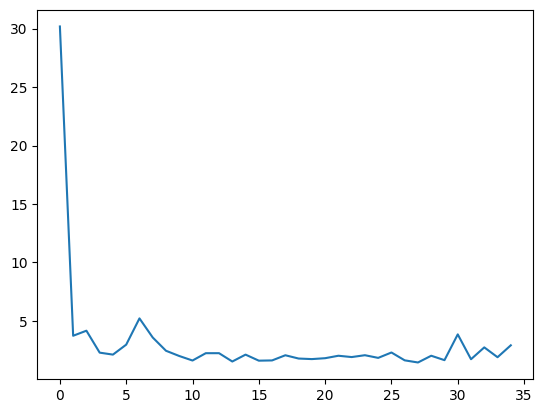

15.821959478297487
16.49874939775774
-0.5183417797088623
-0.5172557830810547
-0.5190305709838867
-0.5210516452789307
-0.5142555236816406
Chi-Square score:  1
Repley's K:  (107.27332240563284, 4.768347705174272)


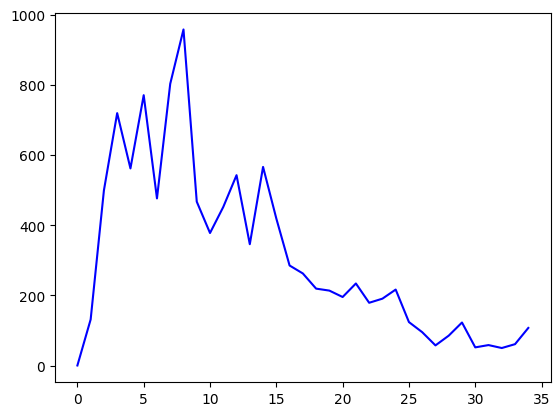

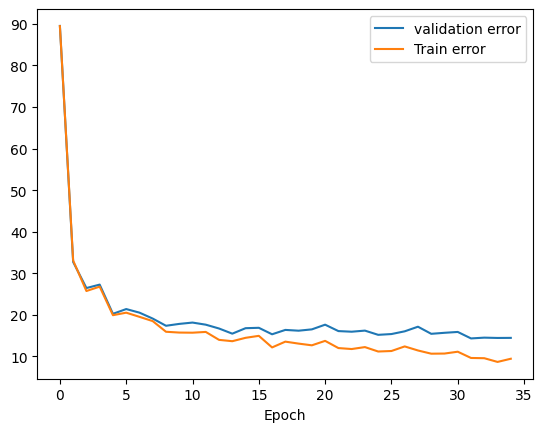

Epoch [36/100], Loss: 1.7783
Train Accuracy: 90.37%
Test Accuracy: 84.48%
Variance to keep :  0.5212998607555005  number of components :  3
[30.173871180706243, 3.738133341550897, 4.169588514691454, 2.2940561276712494, 2.126468509374429, 2.97799409739451, 5.222482064279941, 3.588706593976899, 2.4553639152229088, 2.007984798531697, 1.62115138223387, 2.247434907883317, 2.2485094373376966, 1.536786214992159, 2.125918621230803, 1.6088075615473532, 1.6295129267661719, 2.071675923722519, 1.790502582329297, 1.7437192117612774, 1.8197687968138745, 2.0292338566191734, 1.9170648058008848, 2.0750796715538895, 1.84692541837599, 2.3074218787778684, 1.6364008570301327, 1.454098178304164, 2.029749688199856, 1.6527796581386283, 3.8562605498242633, 1.731359723642224, 2.7444459599019715, 1.9041492495152266, 2.9221584182151057, 2.430080713348667]


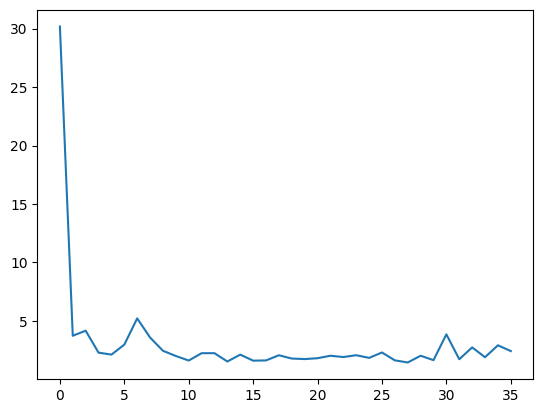

14.805168696897761
15.520787725957897
-0.5534875392913818
-0.5494418144226074
-0.5464322566986084
-0.5481791496276855
-0.5501594543457031
Chi-Square score:  1
Repley's K:  (48.374977798088146, 1.7185575598907705)


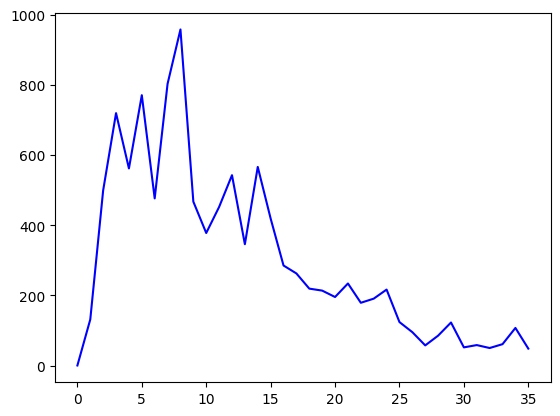

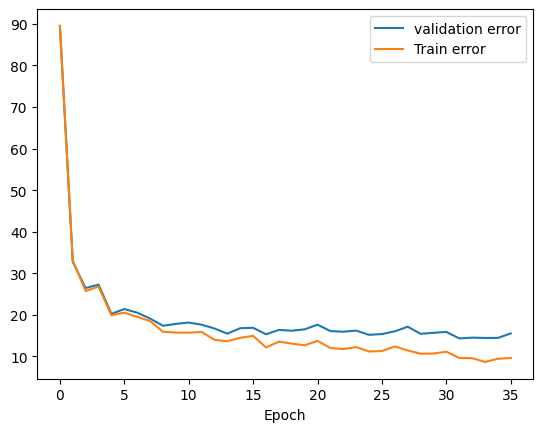

Epoch [37/100], Loss: 1.8094
Train Accuracy: 91.08%
Test Accuracy: 84.80%
Variance to keep :  0.5248302398722482  number of components :  3
[30.173871180706243, 3.738133341550897, 4.169588514691454, 2.2940561276712494, 2.126468509374429, 2.97799409739451, 5.222482064279941, 3.588706593976899, 2.4553639152229088, 2.007984798531697, 1.62115138223387, 2.247434907883317, 2.2485094373376966, 1.536786214992159, 2.125918621230803, 1.6088075615473532, 1.6295129267661719, 2.071675923722519, 1.790502582329297, 1.7437192117612774, 1.8197687968138745, 2.0292338566191734, 1.9170648058008848, 2.0750796715538895, 1.84692541837599, 2.3074218787778684, 1.6364008570301327, 1.454098178304164, 2.029749688199856, 1.6527796581386283, 3.8562605498242633, 1.731359723642224, 2.7444459599019715, 1.9041492495152266, 2.9221584182151057, 2.430080713348667, 1.7483179986609438]


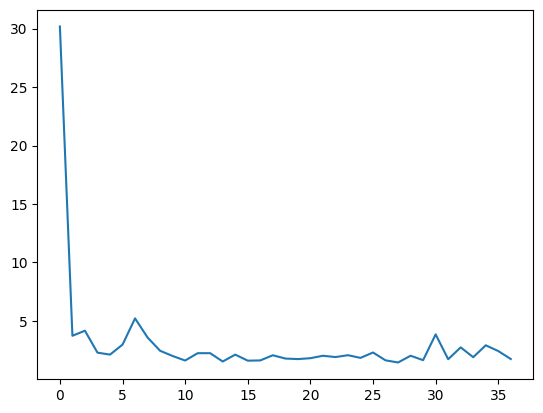

16.782318517079286
18.79512219973743
-0.5065343379974365
-0.5140101909637451
-0.5099184513092041
-0.5086569786071777
-0.5103325843811035
Chi-Square score:  1
Repley's K:  (77.58697533476337, 2.478766603185384)


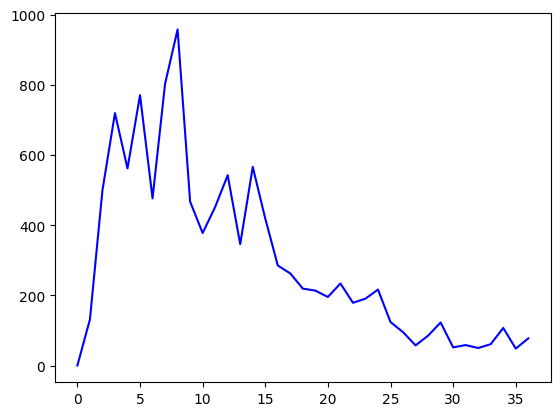

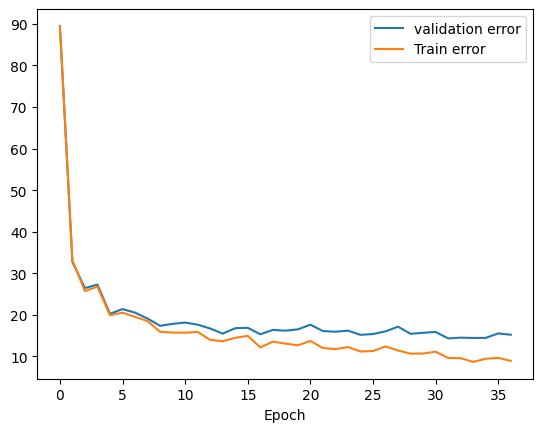

Epoch [38/100], Loss: 1.7716
Train Accuracy: 89.52%
Test Accuracy: 83.63%
Variance to keep :  0.5302694879427614  number of components :  3
[30.173871180706243, 3.738133341550897, 4.169588514691454, 2.2940561276712494, 2.126468509374429, 2.97799409739451, 5.222482064279941, 3.588706593976899, 2.4553639152229088, 2.007984798531697, 1.62115138223387, 2.247434907883317, 2.2485094373376966, 1.536786214992159, 2.125918621230803, 1.6088075615473532, 1.6295129267661719, 2.071675923722519, 1.790502582329297, 1.7437192117612774, 1.8197687968138745, 2.0292338566191734, 1.9170648058008848, 2.0750796715538895, 1.84692541837599, 2.3074218787778684, 1.6364008570301327, 1.454098178304164, 2.029749688199856, 1.6527796581386283, 3.8562605498242633, 1.731359723642224, 2.7444459599019715, 1.9041492495152266, 2.9221584182151057, 2.430080713348667, 1.7483179986609438, 1.7700878055351663]


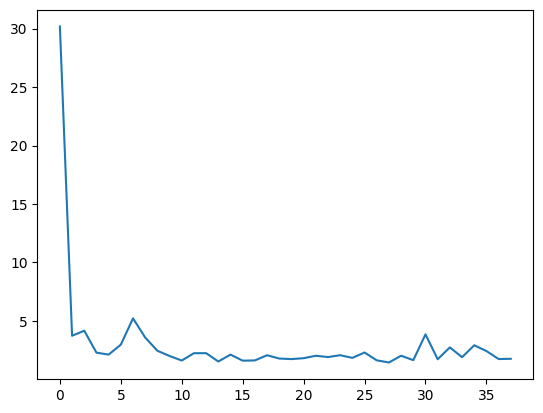

16.11814618639244
17.413389587840747
-0.5151979923248291
-0.5131185054779053
-0.5098116397857666
-0.5159528255462646
-0.5186114311218262
Chi-Square score:  1
Repley's K:  (117.76232805551425, 7.663629579733171)


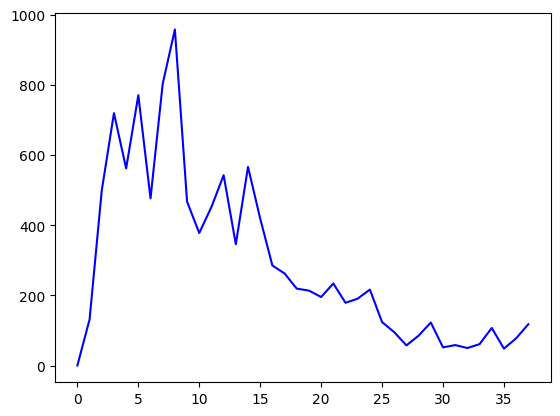

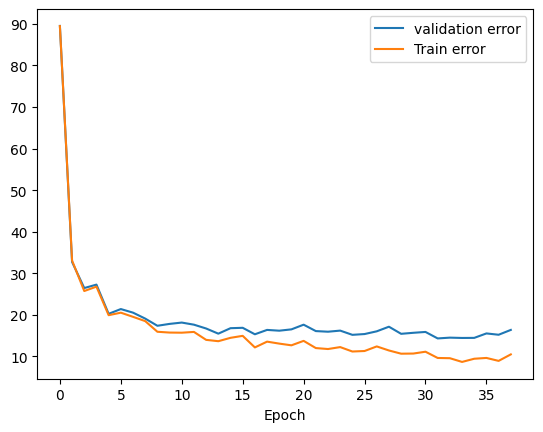

Epoch [39/100], Loss: 1.8158
Train Accuracy: 91.87%
Test Accuracy: 85.17%
Variance to keep :  0.5038926532292374  number of components :  3
[30.173871180706243, 3.738133341550897, 4.169588514691454, 2.2940561276712494, 2.126468509374429, 2.97799409739451, 5.222482064279941, 3.588706593976899, 2.4553639152229088, 2.007984798531697, 1.62115138223387, 2.247434907883317, 2.2485094373376966, 1.536786214992159, 2.125918621230803, 1.6088075615473532, 1.6295129267661719, 2.071675923722519, 1.790502582329297, 1.7437192117612774, 1.8197687968138745, 2.0292338566191734, 1.9170648058008848, 2.0750796715538895, 1.84692541837599, 2.3074218787778684, 1.6364008570301327, 1.454098178304164, 2.029749688199856, 1.6527796581386283, 3.8562605498242633, 1.731359723642224, 2.7444459599019715, 1.9041492495152266, 2.9221584182151057, 2.430080713348667, 1.7483179986609438, 1.7700878055351663, 1.796720648660759]


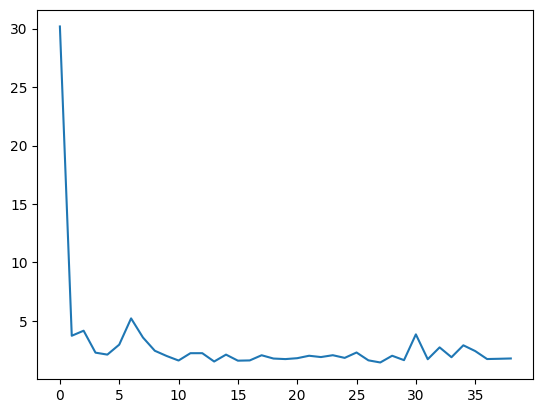

16.11928898873443
17.476178048617264
-0.5311212539672852
-0.5288758277893066
-0.5297610759735107
-0.5291790962219238
-0.5306696891784668
Chi-Square score:  1
Repley's K:  (49.455126825913936, 2.5107891860372873)


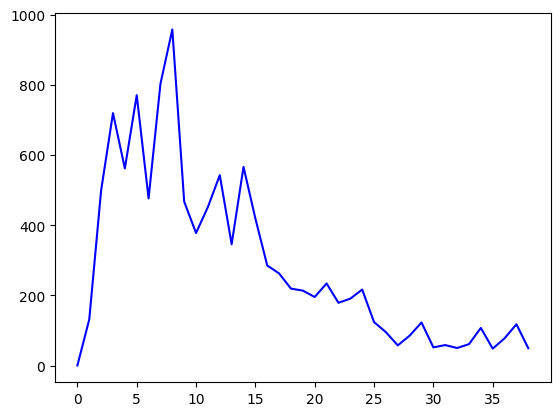

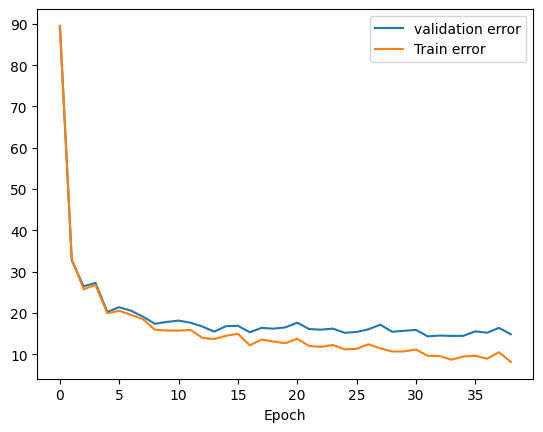

Epoch [40/100], Loss: 1.7787
Train Accuracy: 90.10%
Test Accuracy: 84.40%
Variance to keep :  0.4940788733221779  number of components :  3
[30.173871180706243, 3.738133341550897, 4.169588514691454, 2.2940561276712494, 2.126468509374429, 2.97799409739451, 5.222482064279941, 3.588706593976899, 2.4553639152229088, 2.007984798531697, 1.62115138223387, 2.247434907883317, 2.2485094373376966, 1.536786214992159, 2.125918621230803, 1.6088075615473532, 1.6295129267661719, 2.071675923722519, 1.790502582329297, 1.7437192117612774, 1.8197687968138745, 2.0292338566191734, 1.9170648058008848, 2.0750796715538895, 1.84692541837599, 2.3074218787778684, 1.6364008570301327, 1.454098178304164, 2.029749688199856, 1.6527796581386283, 3.8562605498242633, 1.731359723642224, 2.7444459599019715, 1.9041492495152266, 2.9221584182151057, 2.430080713348667, 1.7483179986609438, 1.7700878055351663, 1.796720648660759, 1.85966569918106]


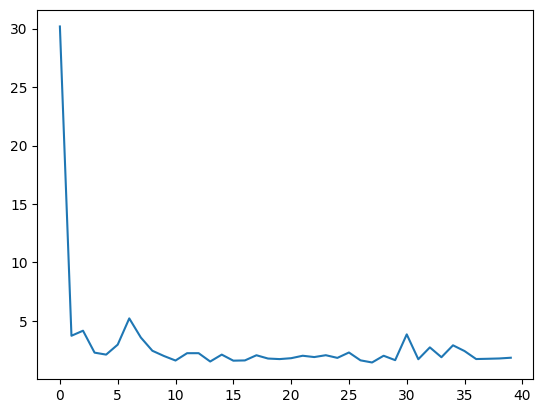

16.078706413540512
17.150158687985975
-0.5222570896148682
-0.5198161602020264
-0.5199105739593506
-0.5194458961486816
-0.5202860832214355
Chi-Square score:  1
Repley's K:  (63.47597162767714, 3.349911784502171)


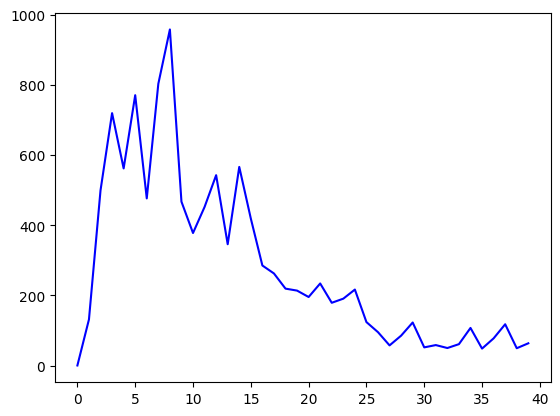

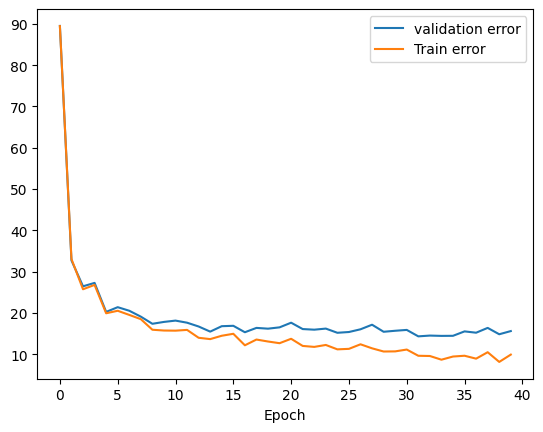

Epoch [41/100], Loss: 1.7791
Train Accuracy: 92.21%
Test Accuracy: 85.87%
Variance to keep :  0.5186544832358819  number of components :  3
[30.173871180706243, 3.738133341550897, 4.169588514691454, 2.2940561276712494, 2.126468509374429, 2.97799409739451, 5.222482064279941, 3.588706593976899, 2.4553639152229088, 2.007984798531697, 1.62115138223387, 2.247434907883317, 2.2485094373376966, 1.536786214992159, 2.125918621230803, 1.6088075615473532, 1.6295129267661719, 2.071675923722519, 1.790502582329297, 1.7437192117612774, 1.8197687968138745, 2.0292338566191734, 1.9170648058008848, 2.0750796715538895, 1.84692541837599, 2.3074218787778684, 1.6364008570301327, 1.454098178304164, 2.029749688199856, 1.6527796581386283, 3.8562605498242633, 1.731359723642224, 2.7444459599019715, 1.9041492495152266, 2.9221584182151057, 2.430080713348667, 1.7483179986609438, 1.7700878055351663, 1.796720648660759, 1.85966569918106, 1.7490274509798927]


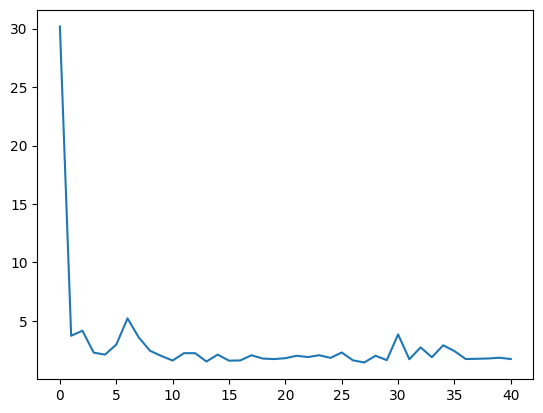

15.272523032642498
16.47773130214653
-0.5496652126312256
-0.5465738773345947
-0.542090654373169
-0.5453131198883057
-0.5476365089416504
Chi-Square score:  1
Repley's K:  (39.637888146989525, 1.3392340515981502)


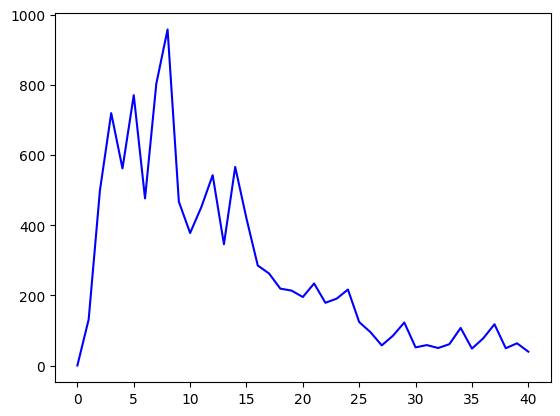

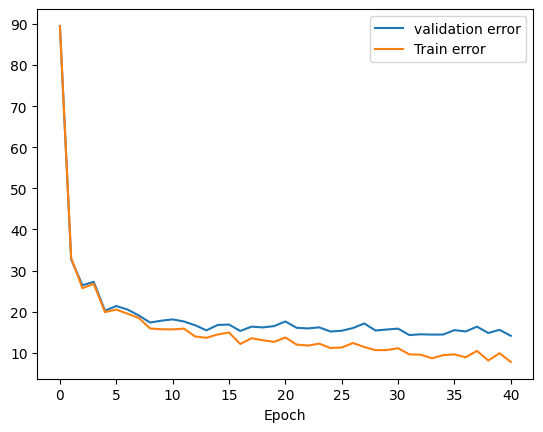

Epoch [42/100], Loss: 1.7896
Train Accuracy: 92.07%
Test Accuracy: 84.97%
Variance to keep :  0.5077160668960795  number of components :  3
[30.173871180706243, 3.738133341550897, 4.169588514691454, 2.2940561276712494, 2.126468509374429, 2.97799409739451, 5.222482064279941, 3.588706593976899, 2.4553639152229088, 2.007984798531697, 1.62115138223387, 2.247434907883317, 2.2485094373376966, 1.536786214992159, 2.125918621230803, 1.6088075615473532, 1.6295129267661719, 2.071675923722519, 1.790502582329297, 1.7437192117612774, 1.8197687968138745, 2.0292338566191734, 1.9170648058008848, 2.0750796715538895, 1.84692541837599, 2.3074218787778684, 1.6364008570301327, 1.454098178304164, 2.029749688199856, 1.6527796581386283, 3.8562605498242633, 1.731359723642224, 2.7444459599019715, 1.9041492495152266, 2.9221584182151057, 2.430080713348667, 1.7483179986609438, 1.7700878055351663, 1.796720648660759, 1.85966569918106, 1.7490274509798927, 2.0691109974744637]


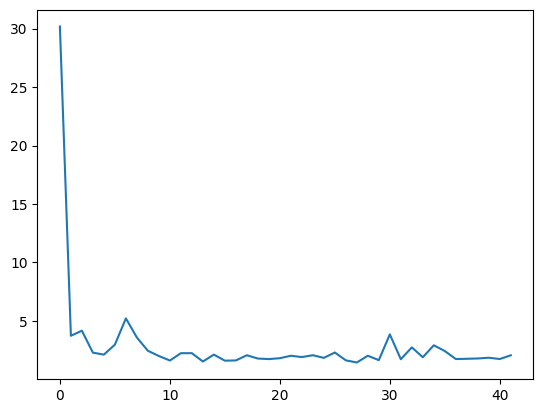

16.13379748065373
17.364498449312705
-0.5504591464996338
-0.551525354385376
-0.5463624000549316
-0.5450048446655273
-0.5505797863006592
Chi-Square score:  1
Repley's K:  (25.847383866997237, 1.5680326960298563)


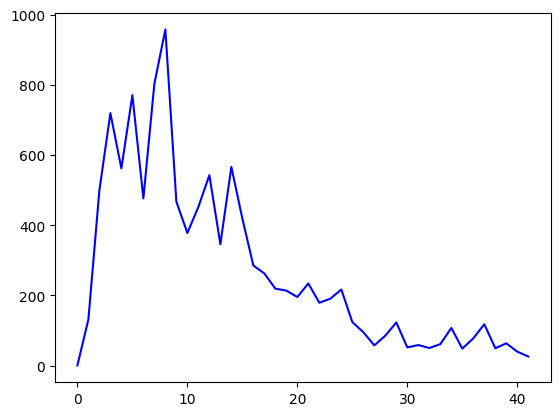

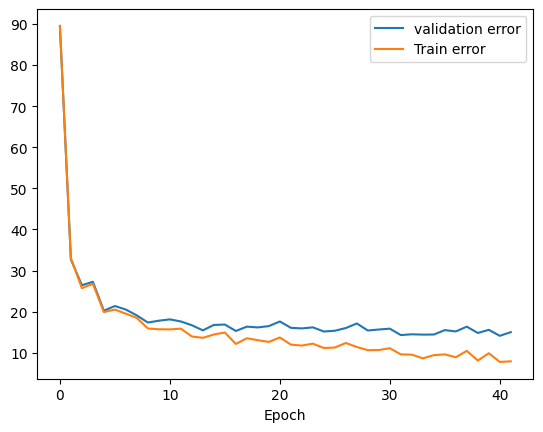

Epoch [43/100], Loss: 1.7536
Train Accuracy: 92.70%
Test Accuracy: 85.57%
Variance to keep :  0.4825709235539333  number of components :  3
[30.173871180706243, 3.738133341550897, 4.169588514691454, 2.2940561276712494, 2.126468509374429, 2.97799409739451, 5.222482064279941, 3.588706593976899, 2.4553639152229088, 2.007984798531697, 1.62115138223387, 2.247434907883317, 2.2485094373376966, 1.536786214992159, 2.125918621230803, 1.6088075615473532, 1.6295129267661719, 2.071675923722519, 1.790502582329297, 1.7437192117612774, 1.8197687968138745, 2.0292338566191734, 1.9170648058008848, 2.0750796715538895, 1.84692541837599, 2.3074218787778684, 1.6364008570301327, 1.454098178304164, 2.029749688199856, 1.6527796581386283, 3.8562605498242633, 1.731359723642224, 2.7444459599019715, 1.9041492495152266, 2.9221584182151057, 2.430080713348667, 1.7483179986609438, 1.7700878055351663, 1.796720648660759, 1.85966569918106, 1.7490274509798927, 2.0691109974744637, 2.4491054522905085]


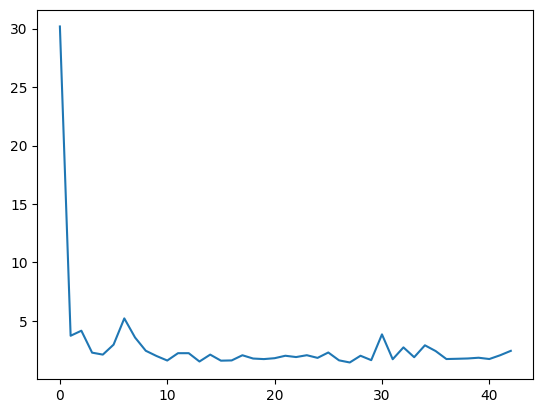

16.637334263817134
17.749531244439773
-0.5297601222991943
-0.5234744548797607
-0.5270674228668213
-0.5267744064331055
-0.5260980129241943
Chi-Square score:  1
Repley's K:  (47.308819707768606, 2.398849181320727)


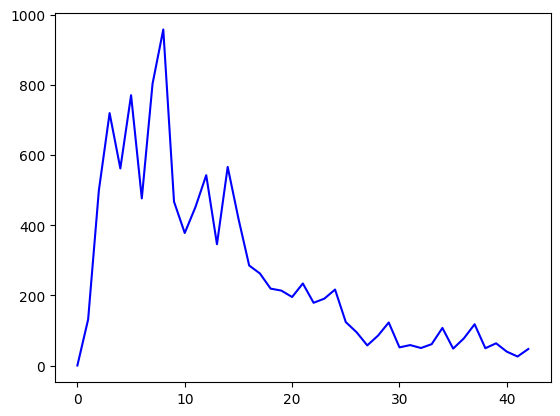

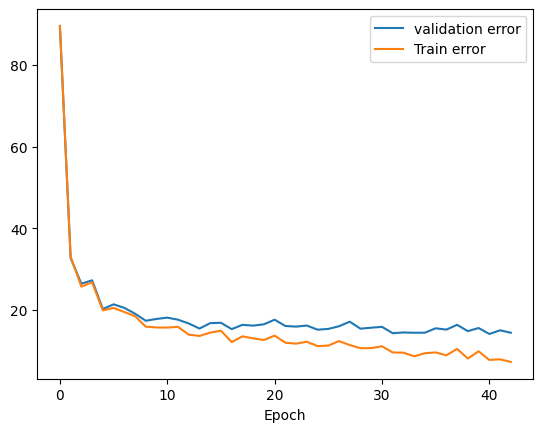

Epoch [44/100], Loss: 1.7101
Train Accuracy: 92.85%
Test Accuracy: 85.49%
Variance to keep :  0.498506466773464  number of components :  3
[30.173871180706243, 3.738133341550897, 4.169588514691454, 2.2940561276712494, 2.126468509374429, 2.97799409739451, 5.222482064279941, 3.588706593976899, 2.4553639152229088, 2.007984798531697, 1.62115138223387, 2.247434907883317, 2.2485094373376966, 1.536786214992159, 2.125918621230803, 1.6088075615473532, 1.6295129267661719, 2.071675923722519, 1.790502582329297, 1.7437192117612774, 1.8197687968138745, 2.0292338566191734, 1.9170648058008848, 2.0750796715538895, 1.84692541837599, 2.3074218787778684, 1.6364008570301327, 1.454098178304164, 2.029749688199856, 1.6527796581386283, 3.8562605498242633, 1.731359723642224, 2.7444459599019715, 1.9041492495152266, 2.9221584182151057, 2.430080713348667, 1.7483179986609438, 1.7700878055351663, 1.796720648660759, 1.85966569918106, 1.7490274509798927, 2.0691109974744637, 2.4491054522905085, 1.604808337686458]


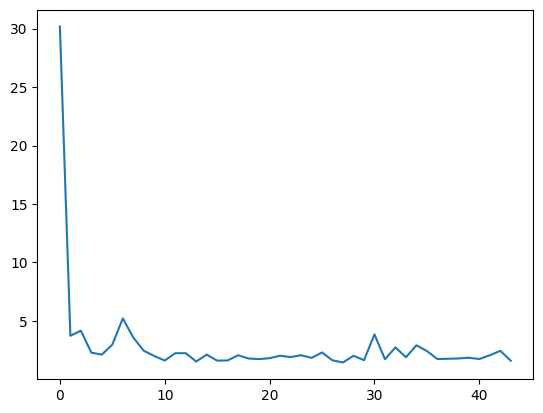

15.64621164298111
16.464055788811272
-0.5480220317840576
-0.5440399646759033
-0.5421102046966553
-0.5452473163604736
-0.5358655452728271
Chi-Square score:  1
Repley's K:  (38.797546441591585, 0.9936628086865633)


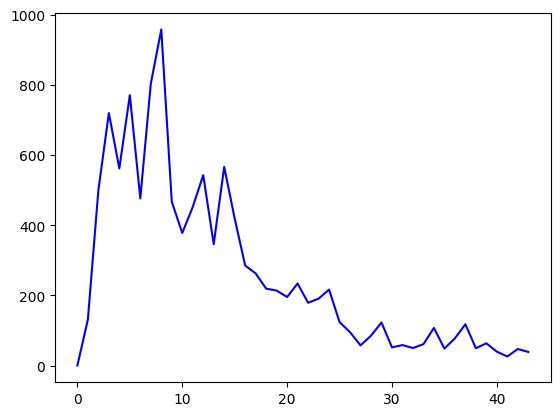

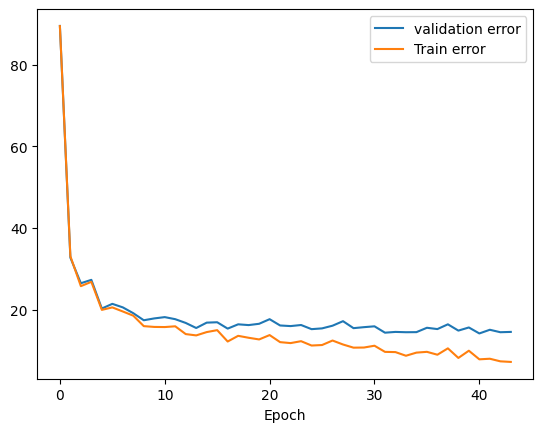

Epoch [45/100], Loss: 1.7440
Train Accuracy: 92.91%
Test Accuracy: 85.60%
Variance to keep :  0.5091371044088222  number of components :  3
[30.173871180706243, 3.738133341550897, 4.169588514691454, 2.2940561276712494, 2.126468509374429, 2.97799409739451, 5.222482064279941, 3.588706593976899, 2.4553639152229088, 2.007984798531697, 1.62115138223387, 2.247434907883317, 2.2485094373376966, 1.536786214992159, 2.125918621230803, 1.6088075615473532, 1.6295129267661719, 2.071675923722519, 1.790502582329297, 1.7437192117612774, 1.8197687968138745, 2.0292338566191734, 1.9170648058008848, 2.0750796715538895, 1.84692541837599, 2.3074218787778684, 1.6364008570301327, 1.454098178304164, 2.029749688199856, 1.6527796581386283, 3.8562605498242633, 1.731359723642224, 2.7444459599019715, 1.9041492495152266, 2.9221584182151057, 2.430080713348667, 1.7483179986609438, 1.7700878055351663, 1.796720648660759, 1.85966569918106, 1.7490274509798927, 2.0691109974744637, 2.4491054522905085, 1.604808337686458, 1.60

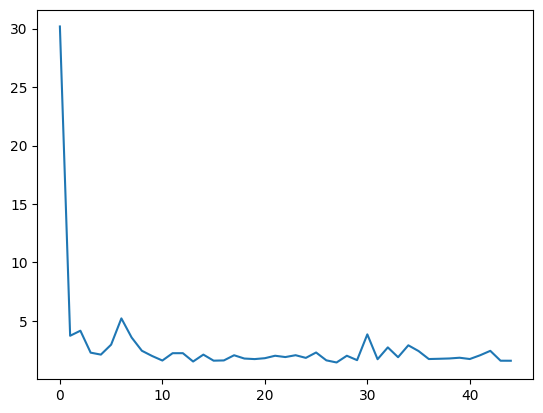

18.44302523849857
20.57507354262054
-0.5176997184753418
-0.5176784992218018
-0.5209853649139404
-0.5180847644805908
-0.5255241394042969
Chi-Square score:  1
Repley's K:  (30.27681721825724, 1.7453648905285415)


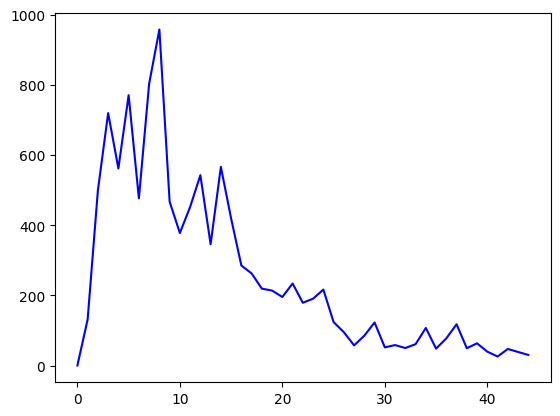

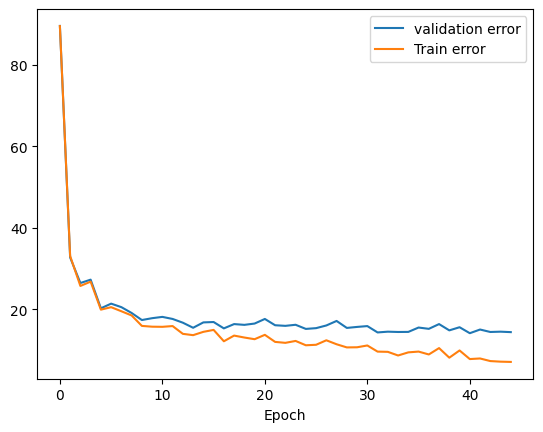

Epoch [46/100], Loss: 1.7231
Train Accuracy: 92.79%
Test Accuracy: 85.00%
Variance to keep :  0.5104967264438841  number of components :  3
[30.173871180706243, 3.738133341550897, 4.169588514691454, 2.2940561276712494, 2.126468509374429, 2.97799409739451, 5.222482064279941, 3.588706593976899, 2.4553639152229088, 2.007984798531697, 1.62115138223387, 2.247434907883317, 2.2485094373376966, 1.536786214992159, 2.125918621230803, 1.6088075615473532, 1.6295129267661719, 2.071675923722519, 1.790502582329297, 1.7437192117612774, 1.8197687968138745, 2.0292338566191734, 1.9170648058008848, 2.0750796715538895, 1.84692541837599, 2.3074218787778684, 1.6364008570301327, 1.454098178304164, 2.029749688199856, 1.6527796581386283, 3.8562605498242633, 1.731359723642224, 2.7444459599019715, 1.9041492495152266, 2.9221584182151057, 2.430080713348667, 1.7483179986609438, 1.7700878055351663, 1.796720648660759, 1.85966569918106, 1.7490274509798927, 2.0691109974744637, 2.4491054522905085, 1.604808337686458, 1.60

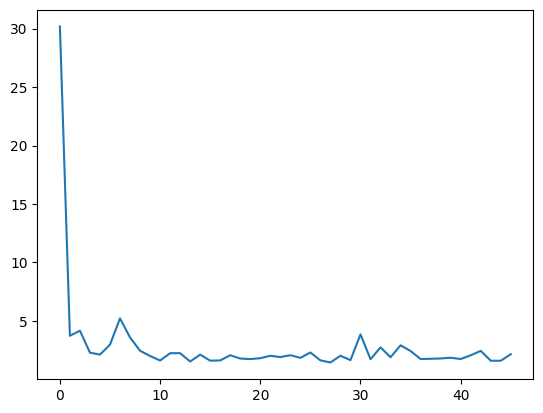

17.218993443348527
18.14027018106882
-0.5243215560913086
-0.5209400653839111
-0.5283713340759277
-0.5255448818206787
-0.5237493515014648
Chi-Square score:  1
Repley's K:  (33.87302751974254, 1.4106892285490977)


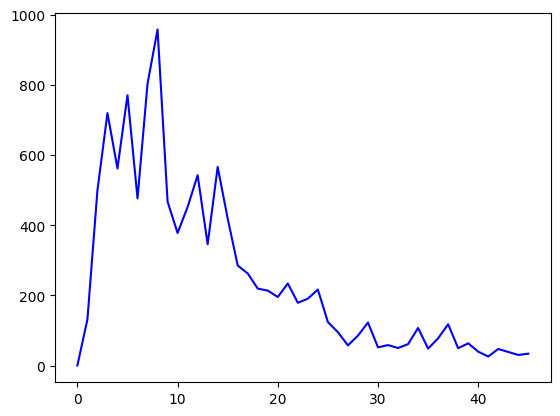

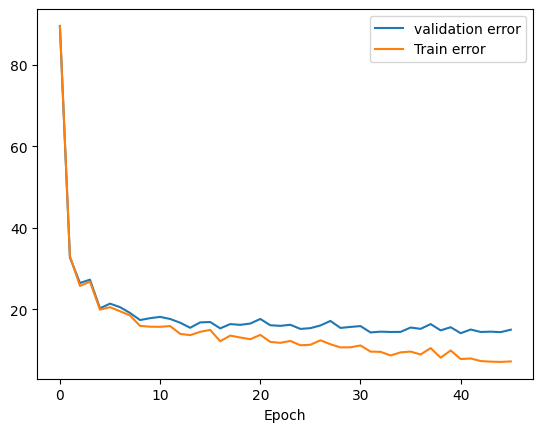

Epoch [47/100], Loss: 1.7293
Train Accuracy: 92.48%
Test Accuracy: 84.98%
Variance to keep :  0.5161788605059565  number of components :  3
[30.173871180706243, 3.738133341550897, 4.169588514691454, 2.2940561276712494, 2.126468509374429, 2.97799409739451, 5.222482064279941, 3.588706593976899, 2.4553639152229088, 2.007984798531697, 1.62115138223387, 2.247434907883317, 2.2485094373376966, 1.536786214992159, 2.125918621230803, 1.6088075615473532, 1.6295129267661719, 2.071675923722519, 1.790502582329297, 1.7437192117612774, 1.8197687968138745, 2.0292338566191734, 1.9170648058008848, 2.0750796715538895, 1.84692541837599, 2.3074218787778684, 1.6364008570301327, 1.454098178304164, 2.029749688199856, 1.6527796581386283, 3.8562605498242633, 1.731359723642224, 2.7444459599019715, 1.9041492495152266, 2.9221584182151057, 2.430080713348667, 1.7483179986609438, 1.7700878055351663, 1.796720648660759, 1.85966569918106, 1.7490274509798927, 2.0691109974744637, 2.4491054522905085, 1.604808337686458, 1.60

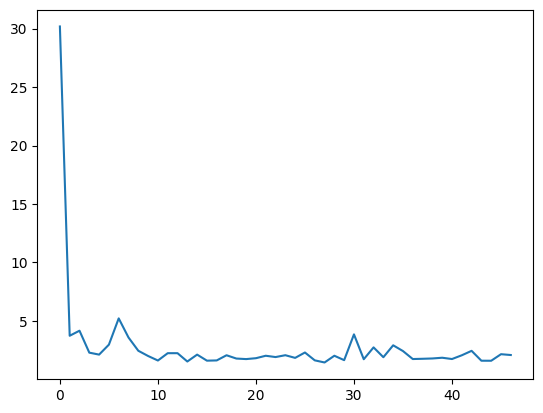

16.596370981429697
17.50223069912289
-0.5384399890899658
-0.5314099788665771
-0.53212571144104
-0.5345630645751953
-0.5321733951568604
Chi-Square score:  1
Repley's K:  (30.67354235461331, 1.2199652174370708)


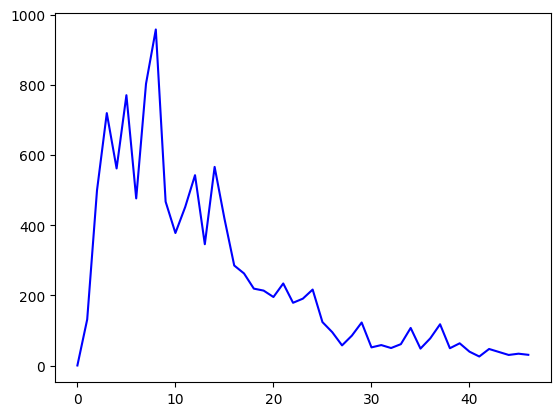

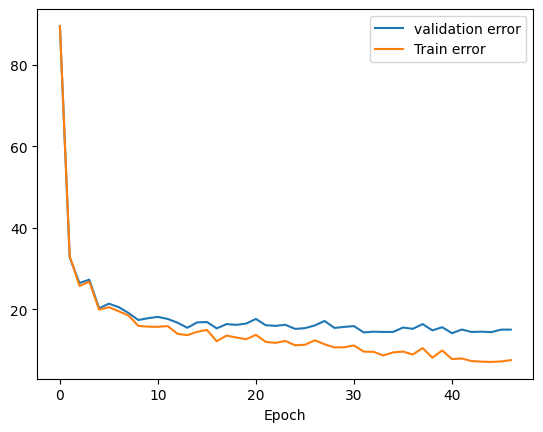

Epoch [48/100], Loss: 1.7023
Train Accuracy: 93.85%
Test Accuracy: 85.77%
Variance to keep :  0.5085990052571958  number of components :  3
[30.173871180706243, 3.738133341550897, 4.169588514691454, 2.2940561276712494, 2.126468509374429, 2.97799409739451, 5.222482064279941, 3.588706593976899, 2.4553639152229088, 2.007984798531697, 1.62115138223387, 2.247434907883317, 2.2485094373376966, 1.536786214992159, 2.125918621230803, 1.6088075615473532, 1.6295129267661719, 2.071675923722519, 1.790502582329297, 1.7437192117612774, 1.8197687968138745, 2.0292338566191734, 1.9170648058008848, 2.0750796715538895, 1.84692541837599, 2.3074218787778684, 1.6364008570301327, 1.454098178304164, 2.029749688199856, 1.6527796581386283, 3.8562605498242633, 1.731359723642224, 2.7444459599019715, 1.9041492495152266, 2.9221584182151057, 2.430080713348667, 1.7483179986609438, 1.7700878055351663, 1.796720648660759, 1.85966569918106, 1.7490274509798927, 2.0691109974744637, 2.4491054522905085, 1.604808337686458, 1.60

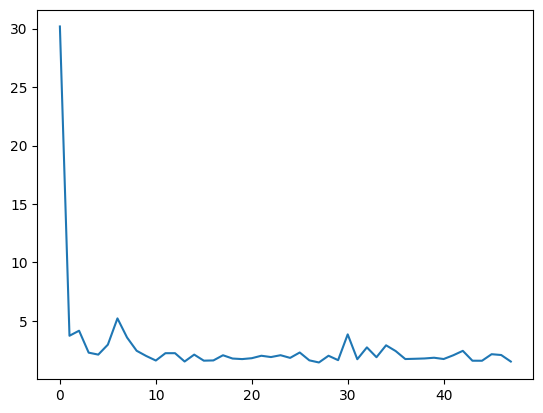

17.045862218574072
18.006604096301892
-0.5362837314605713
-0.5324022769927979
-0.5331845283508301
-0.537224292755127
-0.5372908115386963
Chi-Square score:  1
Repley's K:  (41.4994860696587, 1.2716992811513996)


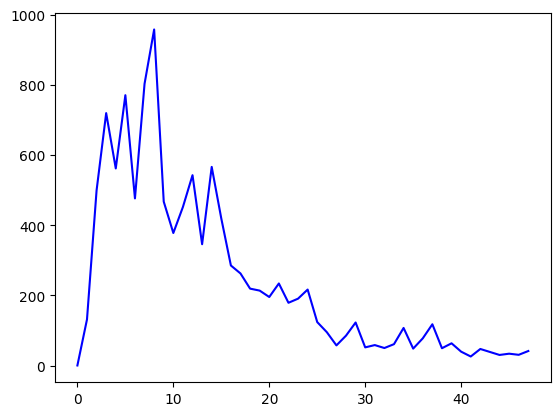

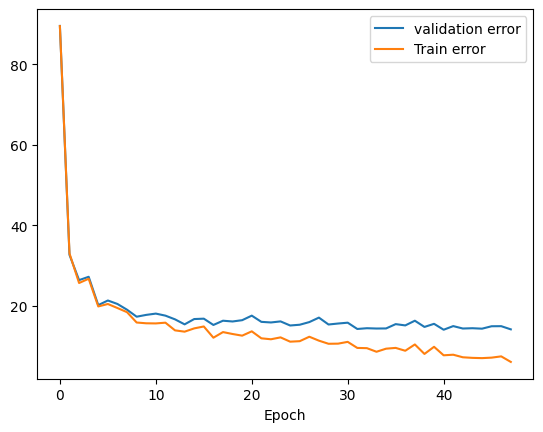

Epoch [49/100], Loss: 1.6599
Train Accuracy: 92.67%


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import backbone.Custom as cust
import backbone.VISUAL as viz
import importlib
import matplotlib.pyplot as plt
import backbone.AstroMLmod as AstroMLmod
import numpy as np
import backbone.TwoNN as TwoNN
import time
import h5py
import skdim
import pickle
from sklearn.metrics import davies_bouldin_score

    
importlib.reload(cust)
importlib.reload(viz)
importlib.reload(AstroMLmod)


def get_data_loaders(Dir = "some/directory", batch_size = 32):

    #obtain  data from a folder a of images
    dataset = torchvision.datasets.ImageFolder(Dir)
    names = [name[0].split('/')[-1] for name in dataset.imgs]
    transformed_dataset = cust.Custom_labelled(dataset,names =names,resize = 256,crop = 224)


    dataset_split = cust.train_val_dataset(transformed_dataset, val_split=0.10)
    

    train_loader = torch.utils.data.DataLoader(dataset_split['train'], batch_size=batch_size, shuffle=True)

    test_loader = torch.utils.data.DataLoader(dataset_split['val'], batch_size=batch_size, shuffle=True)
    
    return train_loader, test_loader

def perturb_list_by_swapping(lst, percentage=5):
    num_swaps = max(1, int(len(lst) * (percentage / 100)))  # Ensure at least one swap
    perturbed_lst = lst[:]  # Copy the list to avoid modifying the original

    for _ in range(num_swaps):
        i, j = random.sample(range(len(lst)), 2)  # Pick two distinct indices
        perturbed_lst[i], perturbed_lst[j] = perturbed_lst[j], perturbed_lst[i]  # Swap them
    
    return perturbed_lst


def galaxyzoo10(batch_size = 256):

    # To get the images and labels from file
    with h5py.File('Galaxy10_DECals.h5', 'r') as F:
        images = np.array(F['images'])
        labels = np.array(F['ans'])
        ids = np.array(F['ra'])
    
    # To convert the labels to categorical 10 classes

    # To convert to desirable type
    labels = labels.astype(np.int64)
    #labels = perturb_list_by_swapping(labels, percentage=5)
    images = images.astype(np.float16)
    

    transformed_dataset = cust.ArrayDataset(images = images,labels =labels,names = ids,resize = 256,crop = 224)


    dataset_split = cust.train_val_dataset(transformed_dataset, train_size = 0.7,val_split=0.3)
    

    train_loader = torch.utils.data.DataLoader(dataset_split['train'], batch_size=batch_size, shuffle=True)

    test_loader = torch.utils.data.DataLoader(dataset_split['val'], batch_size=batch_size, shuffle=True)

    return train_loader, test_loader
    
def evaluate(model, train_loader,test_loader, device):
            
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels,_ in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    
    print(f'Train Accuracy: {100 * correct / total:.2f}%')
    train_accuracy = 100 * correct / total

    correct, total = 0, 0
    with torch.no_grad():
        for images, labels,_ in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Test Accuracy: {100 * correct / total:.2f}%')
    test_accuracy = 100 * correct / total
    torch.cuda.empty_cache()
    #evaluate(model, train_loader, test_loader, device)


    return train_accuracy, test_accuracy




def train_resnet(num_epochs=100, learning_rate=0.0005, Dir ="galaxy_zoo_class_new", batch_size=64, device='cuda'):

    fig = plt.figure(dpi = 300)
    plt.style.use("default")
    plt.figure(figsize=(15,10))
    plt.rcParams.update({'font.size': 20}) 


    train_loader, test_loader = galaxyzoo10(batch_size = batch_size)
    
    model = models.efficientnet_b0(weights = "IMAGENET1K_V1")

    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    #get_representations(model = model,loader = train_loader, batch_size = batch_size, epoch = 0,device  = device)
    model.classifier[1]= nn.Linear(model.classifier[1].in_features, 10) 
    #randomize the weights of the newly added sub-layers
    model.classifier[1].weight.data.normal_(0,0.01)
    model = model.to(device)

    intrinsic_dimension = []
    validation_accuracy = []
    train_accuracy = []
    norm_scores = []
    chi_scores = []
    davies_array = []

    #Obtain train and test accuracies
    
    train, val = evaluate(model, train_loader, test_loader, device)

    #get representatations
    
    test_representations, test_labels = cust.get_representations(model = model,loader = test_loader, batch_size = batch_size, epoch = 0,device  = device)


    val_flat = viz.pca(test_representations,n_components = 3)

    davies =  davies_bouldin_score(val_flat, test_labels)
    davies_array.append(davies)

    

    
    
    #conpute the id_score
    #id_score,std = AstroMLmod.id_score(test_representations)
    
   # intrinsic_dimension.append((id_score,std))
    
    validation_accuracy.append(val)
    train_accuracy.append(train)
    #Faltten the manifold
    epoch = 0
    #val_flat = viz.umap(test_representations,scatter = True,name = "UMAP", dim = 2, min_dist = 0.6, n_neighbors = 50,alpha = 0.2)
    
    """
    pkl_filename = "plots/val_flat"+str(epoch)+".csv"
    with open(pkl_filename, 'wb') as file:
        pickle.dump(val_flat,file)

    #davies_flat =  davies_bouldin_score(val_flat, test_labels)
    #davies_array.append(davies_flat)
    #print("davies flat ", davies_flat)
    """

    
    chi_score, norm_score = AstroMLmod.correlate_and_plot(val_flat,
                                                                      min_dist = 0.0,
                                                                      max_dist =1.5,
                                                                      label = "Correlation on flat manifold for epoch:"+str(epoch),
                                                                    fig_name = "plots/2PCR@Epoch: "+str(epoch),
                                                                  representations = test_representations
                                                             )


    #Append to list for later

    norm_scores.append(norm_score)
    chi_scores.append(chi_score)


        
    fig = plt.figure(dpi = 300)
    plt.style.use("default")
    plt.figure(figsize=(15,10))


    
    for epoch in range(1,num_epochs):
        model.train()
        running_loss = 0.0
        
        for images, labels, names in train_loader:
            
            
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')
        model.eval()
        
        train, val =  evaluate(model, train_loader, test_loader, device)
        #save classification layer for next epoch
        
        class_layer = model.classifier
        
        
        test_representations, test_labels = cust.get_representations(model = model,loader = test_loader, batch_size = batch_size, epoch = 0,device  = device)
        
        
        

        val_flat = viz.pca(test_representations,n_components = 3)

        davies =  davies_bouldin_score(val_flat, test_labels)

    
        #print("Davies boulding score: ", davies)
        #conpute the id_score
        #id_score,std = AstroMLmod.id_score(test_representations)
    
        #intrinsic_dimension.append((id_score,std))
        #y, yerr = zip(*intrinsic_dimension)

        
        #Faltten the manifold
        #val_flat = viz.umap(test_representations,scatter = True,name = "UMAP", dim = 2, min_dist = 0.6, n_neighbors = 50,alpha = 0.2)
        #val_flat = viz.pca(test_representations,n_components = 2)
        """
        davies_flat =  davies_bouldin_score(val_flat, test_labels)
        pkl_filename = "plots/val_flat"+str(epoch)+".csv"
        with open(pkl_filename, 'wb') as file:
            pickle.dump(val_flat,file)
        """

                
        davies_array.append(davies)
        print(davies_array)
        plt.plot(davies_array)
        plt.show()


        #print("davies flat ", davies_flat)

        chi_score, norm_score = AstroMLmod.correlate_and_plot(val_flat,
                                                                      min_dist = 0.0,
                                                                      max_dist =1.5,
                                                                      label = "Correlation on flat manifold for epoch:"+str(epoch),
                                                                      fig_name = "plots/2PCR@Epoch: "+str(epoch),
                                                                     representations = test_representations)


        norm_scores.append(norm_score)
        chi_scores.append(chi_score)




        validation_accuracy.append(val)
        train_accuracy.append(train)
 

        #model.fc = nn.Linear(512, 10) 
        model.classifier = class_layer
        #model.fc = model.fc.to(device)
        
        
        x = np.arange(epoch+1)
        plt.plot([a for a,b in norm_scores], label = "Chi score", color = "blue")
        #plt.fill_between(x, y - yerr, y + yerr, color="blue", alpha=0.3)
        plt.show()
           
        #plt.errorbar(x, y, yerr=yerr, fmt='o', color = "blue", capsize=1)


        plt.plot([100-a for a in validation_accuracy], label = "validation error")
        plt.plot([100-a for a in train_accuracy], label = "Train error")
        plt.xlabel("Epoch")
        plt.legend(loc="upper right")
        plt.show()
        
        if epoch%10 ==0:
            pkl_filename = "davies_chi_scores.csv"
            with open(pkl_filename, 'wb') as file:
                pickle.dump(chi_scores,file)
                
            pkl_filename = "davies_norm_scores.csv"
            with open(pkl_filename, 'wb') as file:
                pickle.dump(norm_scores,file)
                
            pkl_filename = "davies_chi_validation.csv"
            with open(pkl_filename, 'wb') as file:
                pickle.dump(validation_accuracy,file)
                
            pkl_filename = "davies_chi_train.csv"
            with open(pkl_filename, 'wb') as file:
                pickle.dump(train_accuracy,file) 



if __name__ == "__main__":
    train_resnet()

In [ ]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

pkl_filename = "intrinsic_dimension.csv"
with open(pkl_filename, 'rb') as file:
    i_d= pickle.load(file)
        
pkl_filename = "validation.csv"
with open(pkl_filename, 'rb') as file:
    validation_accuracy = pickle.load(file) 

pkl_filename = "train.csv"
with open(pkl_filename, 'rb') as file:
    train_accuracy = pickle.load(file) 

y,yerr = zip(*i_d)
x = range(len(y))
yerr = np.array(yerr)
y = np.array(y)
fig = plt.figure(dpi = 300)
plt.style.use("default")
plt.figure(figsize=(15,10))
plt.rcParams.update({'font.size': 20}) 
plt.plot(y, label = "ID score", color = "blue")
plt.fill_between(x, y - yerr, y + yerr, color="blue", alpha=0.3)

plt.plot([(100-a)/5 for a in validation_accuracy], label = "Validation error/5")
plt.plot([(100-a)/5 for a in train_accuracy], label = "Train error/5")
plt.xlabel("Epoch")
plt.ylim(0,20)

plt.legend(loc="upper right")
plt.show()

In [ ]:
import importlib
import backbone.AstroMLmod as AstroMLmod
import pickle
import matplotlib.pyplot as plt
import backbone.VISUAL as viz
importlib.reload(AstroMLmod)

norm_scores = []
for epoch in range(70):
    
    pkl_filename = "plots/val_flat"+str(epoch)+".csv"
    with open(pkl_filename, 'rb') as file:
        val_flat= pickle.load(file)


    viz.shade(val_flat, predictions = [0]*len(val_flat))

    
    chi_score, norm_score = AstroMLmod.correlate_and_plot(val_flat,
                                                          min_dist = 0.0,
                                                          max_dist =1.5,
                                                          label = "Correlation on flat manifold for epoch:"+str(epoch),
                                                          fig_name = "plots/2PCR@Epoch: "+str(epoch),
                                                          representations = [])

    norm_scores.append(norm_score)

In [ ]:
plt.plot([a for a,b in norm_scores], label = "Chi score", color = "blue")
plt.show()

In [16]:
print(len(val_flat))

7095


In [ ]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(8, 10))


pkl_filename = "chi_scores.csv"

with open(pkl_filename, 'rb') as file:
    chi_scores = pickle.load(file)

    
pkl_filename = "davies_norm_scores.csv"

with open(pkl_filename, 'rb') as file:
    norm_scores = pickle.load(file)

                
    pkl_filename = "davies_chi_validation.csv"
with open(pkl_filename, 'rb') as file:
    validation_scores = pickle.load(file)
                
pkl_filename = "davies_chi_train.csv"

with open(pkl_filename, 'rb') as file:
    train_scores = pickle.load(file)


epochs = np.linspace(0,len(train_scores),len(train_scores))
# Plot each dataset on its own subplot
#axs[0].plot(chi_scores, color='blue', label='Chi-square')
#axs[0].set_ylabel('Chi-square')
#axs[0].legend()

plt.title("K_100 with sub-sumpling error using uniform background (5X)")

axs[1].plot(epochs,[a for a,b in norm_scores], label='K_100')
axs[1].fill_between(epochs,[a-b/2 for a,b in norm_scores],[a+b/2 for a,b in norm_scores], color='green',alpha = 0.3)

axs[1].set_ylabel('K_100')
axs[1].legend()

axs[2].plot([100-a for a in train_scores], label='Train error')
axs[2].plot([100-a for a in validation_scores], label='Validation error')
axs[2].set_ylabel('Error')
axs[2].set_xlabel('x')
axs[2].legend


# Add a global title
#fig.suptitle('Stacked Subplots with Shared X-axis', fontsize=16)

# Adjust spacing
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Show plot
plt.show()

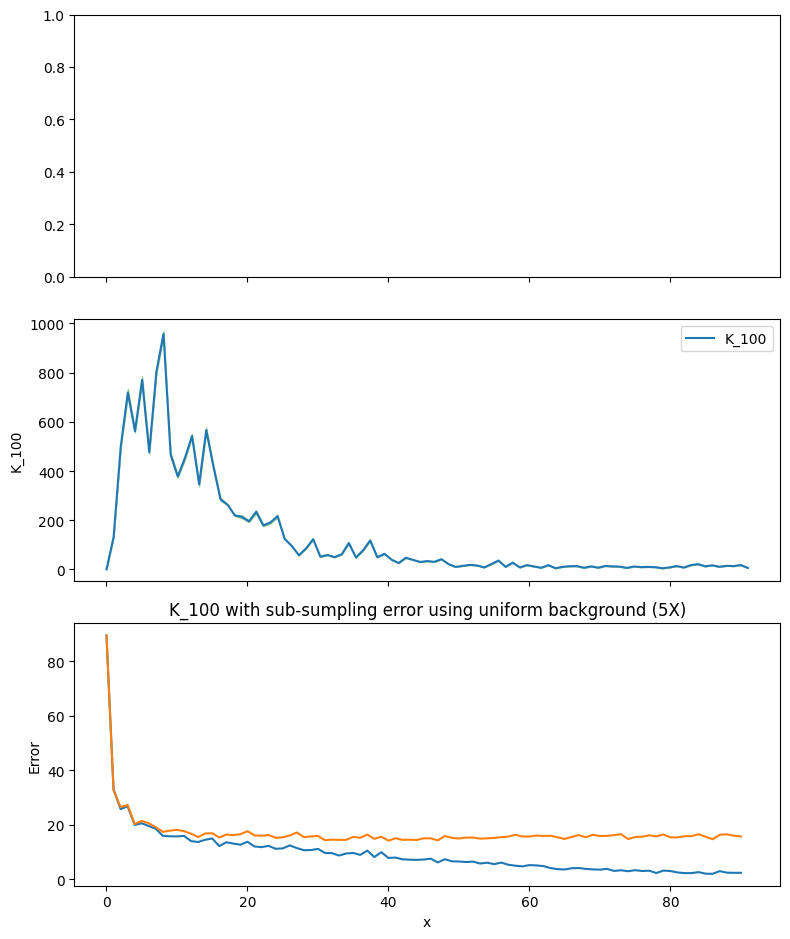

In [ ]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams.update({'font.size': 13})
fig = plt.figure(dpi = 300)

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(10, 8))



pkl_filename = "bad_norm_scores.csv"

with open(pkl_filename, 'rb') as file:
    chi_scores = pickle.load(file)[0:70]
    
pkl_filename = "norm_scores.csv"

with open(pkl_filename, 'rb') as file:
    norm_scores = pickle.load(file)[0:70]

                
    pkl_filename = "chi_validation.csv"
with open(pkl_filename, 'rb') as file:
    validation_scores = pickle.load(file)[0:70]
                
pkl_filename = "chi_train.csv"

with open(pkl_filename, 'rb') as file:
    train_scores = pickle.load(file)[0:70]


                
    pkl_filename = "bad_chi_validation.csv"
with open(pkl_filename, 'rb') as file:
    bad_validation_scores = pickle.load(file)[0:70]
                
pkl_filename = "bad_chi_train.csv"

with open(pkl_filename, 'rb') as file:
    bad_train_scores = pickle.load(file)[0:70]


epochs = np.linspace(0,len(train_scores),len(train_scores))[0:70]
# Plot each dataset on its own subplot
#axs[0].plot(chi_scores, color='blue', label='Chi-square')
#axs[0].set_ylabel('Chi-square')
#axs[0].legend()

#plt.title("K_100 with sub-sumpling error using uniform background (5X)")

axs[1].plot(epochs,[a for a,b in norm_scores], color = 'orange',label='Structure quantity')
axs[1].fill_between(epochs,[a-b/2 for a,b in norm_scores],[a+b/2 for a,b in norm_scores], color='orange',alpha = 0.3)

axs[1].plot(epochs,[a for a,b in chi_scores],linestyle='--',color = 'red', label='Structure quantity (noisy labels)')
axs[1].fill_between(epochs,[a-b/2 for a,b in norm_scores],[a+b/2 for a,b in norm_scores], color='red',alpha = 0.3)



axs[1].set_ylabel('Structure quantity')
axs[1].legend()

axs[0].plot([100-a for a in train_scores], label='Train error')
axs[0].plot([100-a for a in validation_scores], label='Validation error')

axs[0].plot([100-a for a in bad_train_scores], linestyle='--', label='Train error (noisy labels)')
axs[0].plot([100-a for a in bad_validation_scores], linestyle='--',label='Validation error (noisy labels)')
axs[0].set_ylabel('Error')
axs[0].set_xlabel('x')
axs[0].legend()

# Add a global title
#fig.suptitle('Stacked Subplots with Shared X-axis', fontsize=16)

# Adjust spacing
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Show plot
plt.show()

In [ ]:
fig = plt.figure(dpi = 300)
plt.style.use("default")
plt.figure(figsize=(15,10))
plt.rcParams.update({'font.size': 20}) 
plt.scatter(y[1:],[(100-a) for a in validation_accuracy][1:], s = 10)
plt.xlabel("ID score")
plt.ylabel("Validation error")
plt.show()

In [8]:
a = 1000
for i in range(365):
    a +=a*0.001
    a +=1000
100*365-a

-405191.5647430078

In [ ]:
import random


# Example usage
original_list = list(range(10000))
perturbed_list = perturb_list_by_swapping(original_list)


sum(int(a==b) for a,b in zip(original_list,perturbed_list))

In [ ]:
import random
a = np.array([np.array([1231])])
indices = random.sample(range(1),int(1))
indices
a[indices]

In [ ]:

from sklearn.neighbors import KDTree

counts_DD = KDT_D.two_point_correlation(data, bins)